# Quantum Phase Estimation (QPE) for a Custom Unitary

This notebook demonstrates the Quantum Phase Estimation (QPE) algorithm on a custom 3-qubit unitary operator. We construct the unitary, find its eigenvalues and eigenvectors, and run QPE with different numbers of ancilla qubits.

## 1. Import Required Libraries
Import Qiskit, NumPy, and visualization tools.

In [59]:
# Import Qiskit and supporting libraries
import qiskit
from qiskit_aer import AerSimulator, Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout, plot_histogram, circuit_drawer, plot_state_qsphere
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import CZGate

## 2. Build the Custom 3-Qubit Unitary Circuit
The circuit consists of Hadamard, Rz, and CNOT gates.

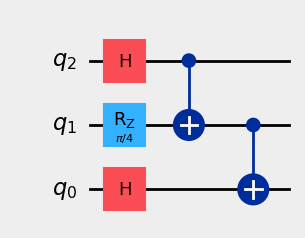

In [60]:
import numpy as np
from qiskit import QuantumCircuit

# Create a 3-qubit circuit for the custom unitary U
qc = QuantumCircuit(3)
qc.h(2)                # Hadamard on q2 (top wire)
qc.rz(np.pi/4, 1)      # Rz(pi/4) on q1 (middle wire)
qc.h(0)                # Hadamard on q0 (bottom wire)
qc.cx(2, 1)            # CNOT: control q2, target q1
qc.cx(1, 0)            # CNOT: control q1, target q0
# (Optional) Add more CNOTs if needed for your custom unitary

# Visualize the circuit
qc.draw('mpl', reverse_bits=True, fold=-1, style={'backgroundcolor': '#EEEEEE'})

## 3. Get the Matrix Representation of the Unitary
Obtain the matrix form of the custom unitary U.

In [61]:
from qiskit.quantum_info import Operator

# Get the matrix form of the circuit
U = Operator(qc).data
print(U)

[[ 0.46193977-0.19134172j  0.46193977-0.19134172j  0.        +0.j
   0.        +0.j          0.46193977-0.19134172j  0.46193977-0.19134172j
   0.        +0.j          0.        +0.j        ]
 [ 0.46193977-0.19134172j -0.46193977+0.19134172j  0.        +0.j
   0.        +0.j          0.46193977-0.19134172j -0.46193977+0.19134172j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.46193977+0.19134172j
  -0.46193977-0.19134172j  0.        +0.j          0.        +0.j
   0.46193977+0.19134172j -0.46193977-0.19134172j]
 [ 0.        +0.j          0.        +0.j          0.46193977+0.19134172j
   0.46193977+0.19134172j  0.        +0.j          0.        +0.j
   0.46193977+0.19134172j  0.46193977+0.19134172j]
 [ 0.        +0.j          0.        +0.j          0.46193977+0.19134172j
   0.46193977+0.19134172j  0.        +0.j          0.        +0.j
  -0.46193977-0.19134172j -0.46193977-0.19134172j]
 [ 0.        +0.j          0.        +0.j    

## 4. Find Eigenvalues and Eigenvectors of U
Use NumPy to compute all eigenvalues and eigenvectors of the unitary matrix.

In [62]:
# Compute all eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(U)

# Print all eigenvalues and corresponding eigenvectors
for i in range(len(eigvals)):
    print(f"Eigenvalue {i}: {eigvals[i]}")
    print(f"Eigenvector {i}:\n{eigvecs[:, i]}\n")

Eigenvalue 0: (-0.08499628518524249-0.9963812681422253j)
Eigenvector 0:
[-0.0395937 +0.21134574j -0.2433541 -0.09994599j -0.21421515-0.24163967j
  0.17855113-0.00863674j  0.06009592+0.09205008j  0.60172771+0.j
  0.0083665 +0.38839298j -0.15224602-0.44728404j]

Eigenvalue 1: (-0.9931153703932932-0.11714034782512606j)
Eigenvector 1:
[-0.23004657-0.11352361j -0.01522873+0.38084008j -0.11393387-0.05824473j
 -0.23437682+0.07681173j  0.57461942+0.j         -0.03868574+0.15547642j
  0.44408251-0.05430281j  0.31357293-0.2395223j ]

Eigenvalue 2: (-0.9238795325112876+0.3826834323650903j)
Eigenvector 2:
[-0.27811132-0.13905566j  0.69527831+0.j         -0.11519748-0.05759874j
  0.05759874-0.11519748j -0.13905566+0.27811132j  0.27811132+0.13905566j
  0.27811132+0.13905566j -0.13905566+0.27811132j]

Eigenvalue 3: (0.6968652160789304-0.7172021128100955j)
Eigenvector 3:
[ 0.54616241+0.j          0.21233722-0.14582547j -0.13958563+0.07875819j
 -0.35446786+0.00664975j  0.09261668-0.43422118j  0.1519446

## 5. Analytically Find an Eigenvector for $e^{ii/8}$
We solve $(U-ambda I)v = 0$ for $ambda = e^{ii/8}$ using SVD.

In [63]:
# Find eigenvector analytically for eigenvalue e^{i pi/8}
lambda_val = np.exp(1j * np.pi/8)
U_minus_lambda = U - lambda_val * np.eye(8)
_, _, vh = np.linalg.svd(U_minus_lambda)
eigenvector = vh[-1]  # Last right singular vector

# Verify that U @ eigenvector ≈ lambda_val * eigenvector
print(np.allclose(U @ eigenvector, lambda_val * eigenvector))

False


## 7. Corrected QPE Implementation (Stable Qubit/Bit Mapping)
The earlier implementation recreated a circuit whose *total* number of qubits changed with `t` (the number of ancilla/phase qubits). Although this is normal, it can be visually confusing in the drawn diagrams because qubit indices shift: with `t=2` there are qubits `q_0,q_1` (ancilla) then the 3 system qubits, but with `t=8` there are `q_0..q_7` (ancilla) before the 3 system qubits. All ancilla are always measured, but their highest index grows with `t`.

To make the mapping explicit and unambiguous we:
- Use named quantum registers: `anc` (phase register) and `sys` (system/eigenstate register)
- Use a separate classical register `c_phase` only for the phase bits (we ignore system qubits in measurement)
- Apply controlled powers of `U` correctly: ancilla `k` controls `U^{2^k}`
- Apply the inverse QFT on the phase register only (with swaps) so that the measured bit string (left→right in printout) corresponds to the binary fraction `0.phi_1 phi_2 ... phi_t`

Below we define a clean, reusable QPE function and run it for `t ∈ {2,4,6,8}`, reporting the dominant phase estimate and the decoded fractional value. This keeps the system qubits in the same (separately named) register regardless of `t`, avoiding the indexing confusion you noticed.

Expected phase decimal = 0.062500


Circuit diagram for t=2 ancilla qubits:


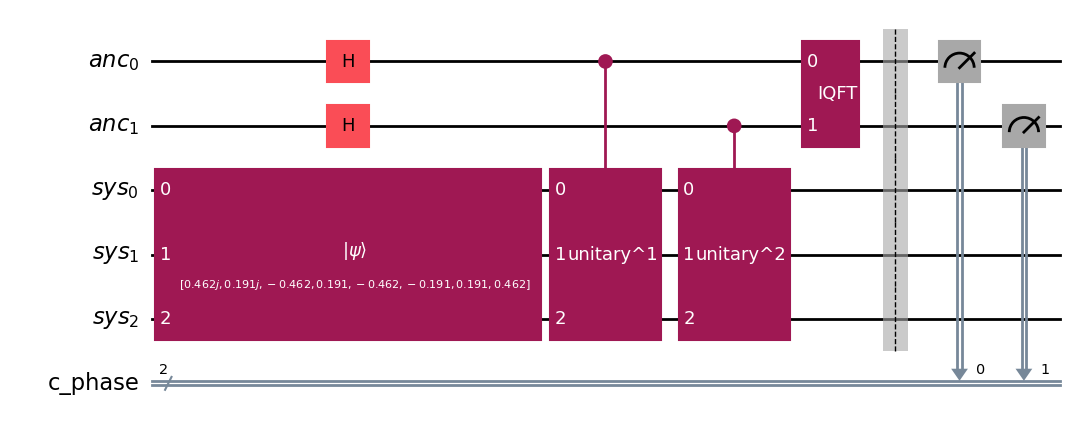

t=2 ancilla -> top bitstring 00 (phase=0.000000, prob=0.818)  error=0.062500
  00 -> 0.000000  count=3350  p=0.818
  01 -> 0.250000  count=433  p=0.106
  11 -> 0.750000  count=179  p=0.044
  10 -> 0.500000  count=134  p=0.033
-------------------------------------------------------

Circuit diagram for t=4 ancilla qubits:


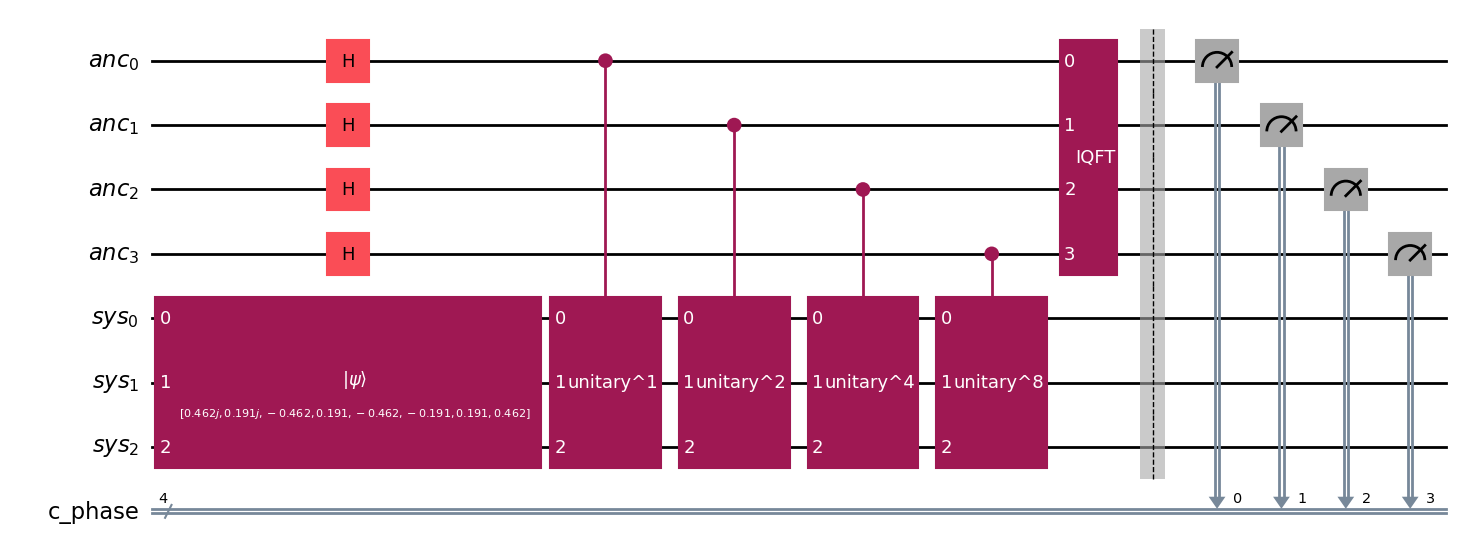

t=4 ancilla -> top bitstring 0001 (phase=0.062500, prob=1.000)  error=0.000000
  0001 -> 0.062500  count=4096  p=1.000
-------------------------------------------------------

Circuit diagram for t=6 ancilla qubits:


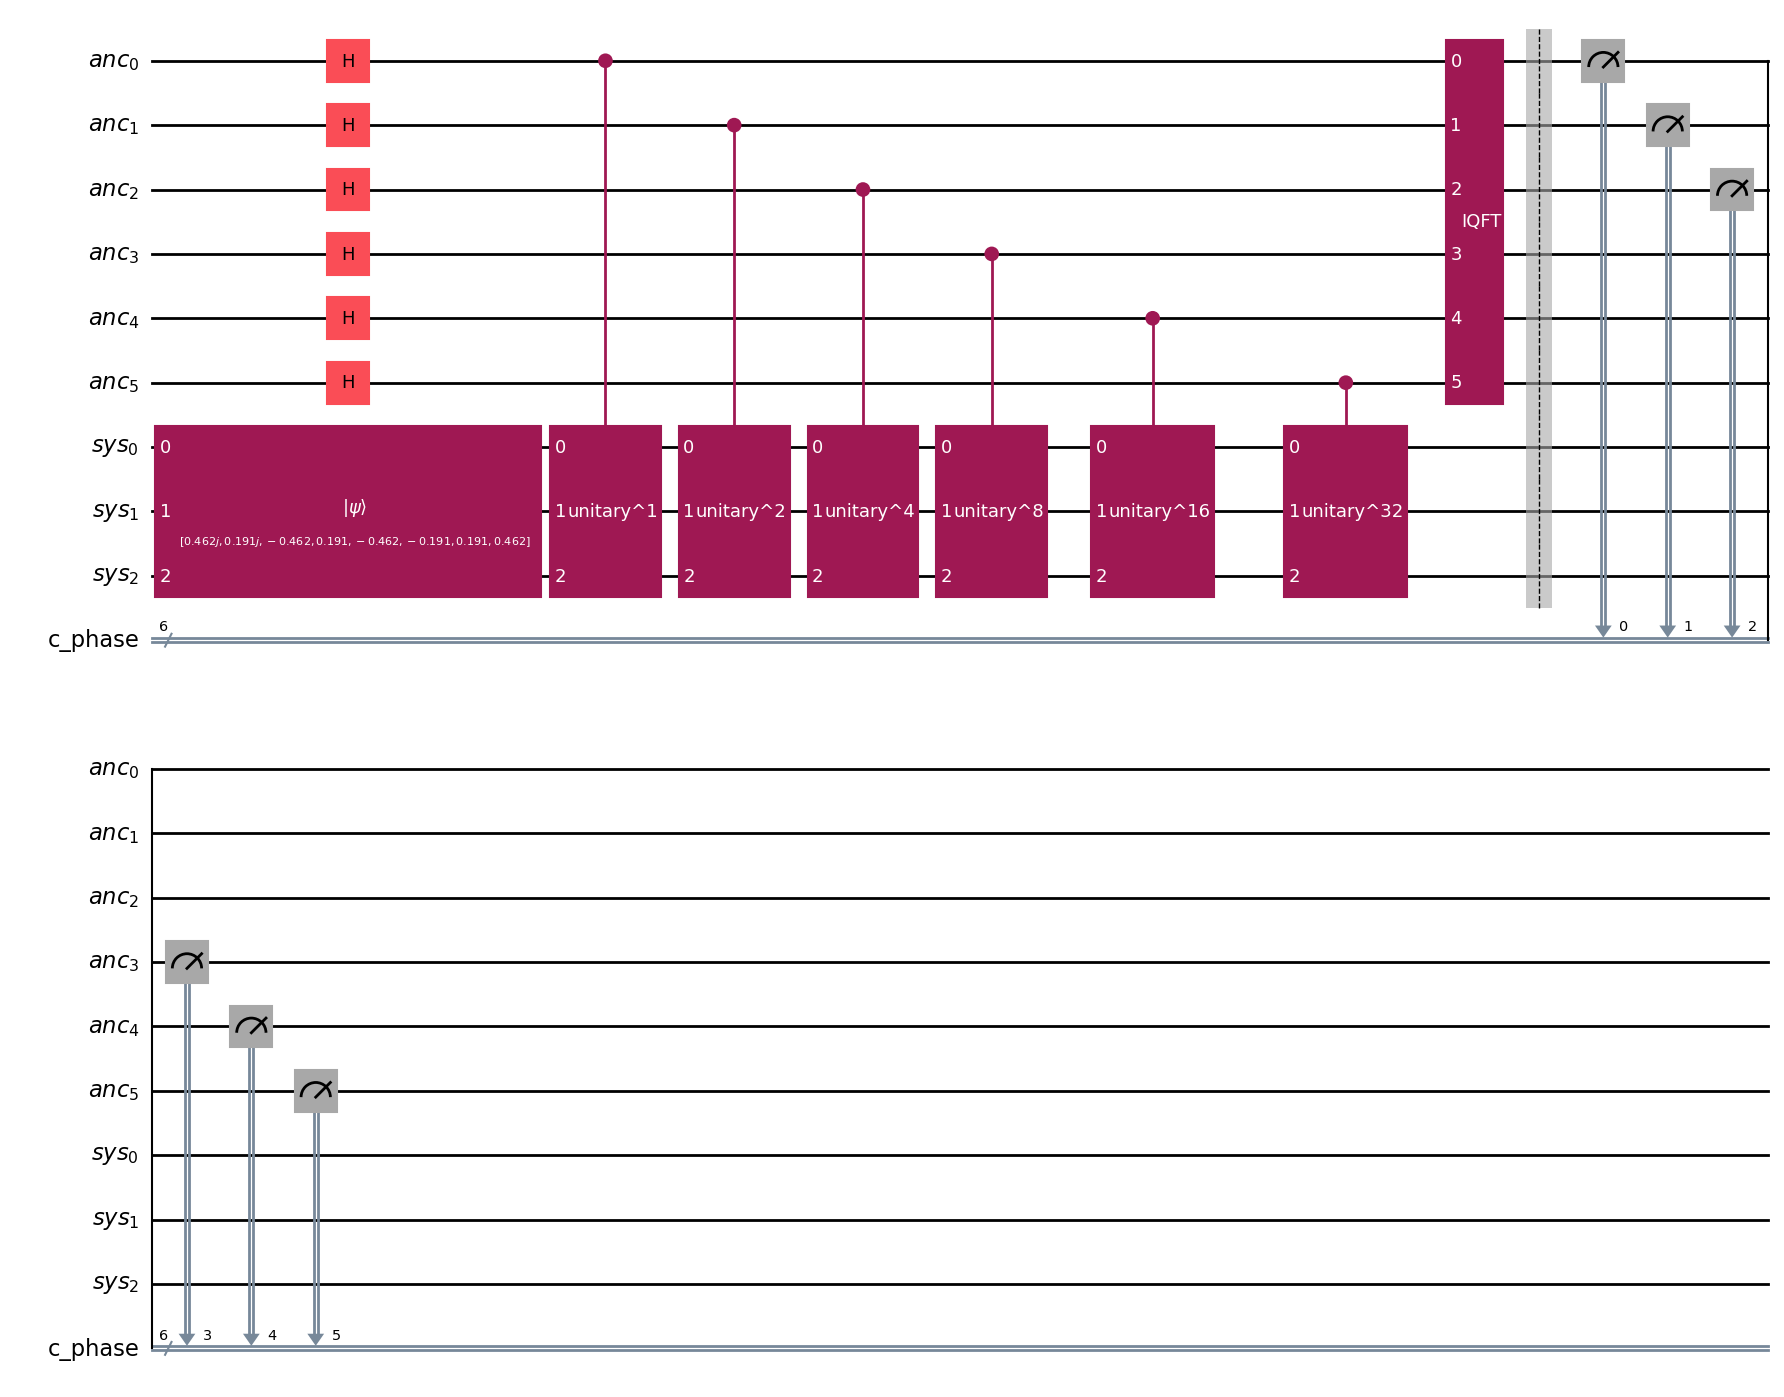

t=6 ancilla -> top bitstring 000100 (phase=0.062500, prob=1.000)  error=0.000000
  000100 -> 0.062500  count=4096  p=1.000
-------------------------------------------------------

Circuit diagram for t=8 ancilla qubits:


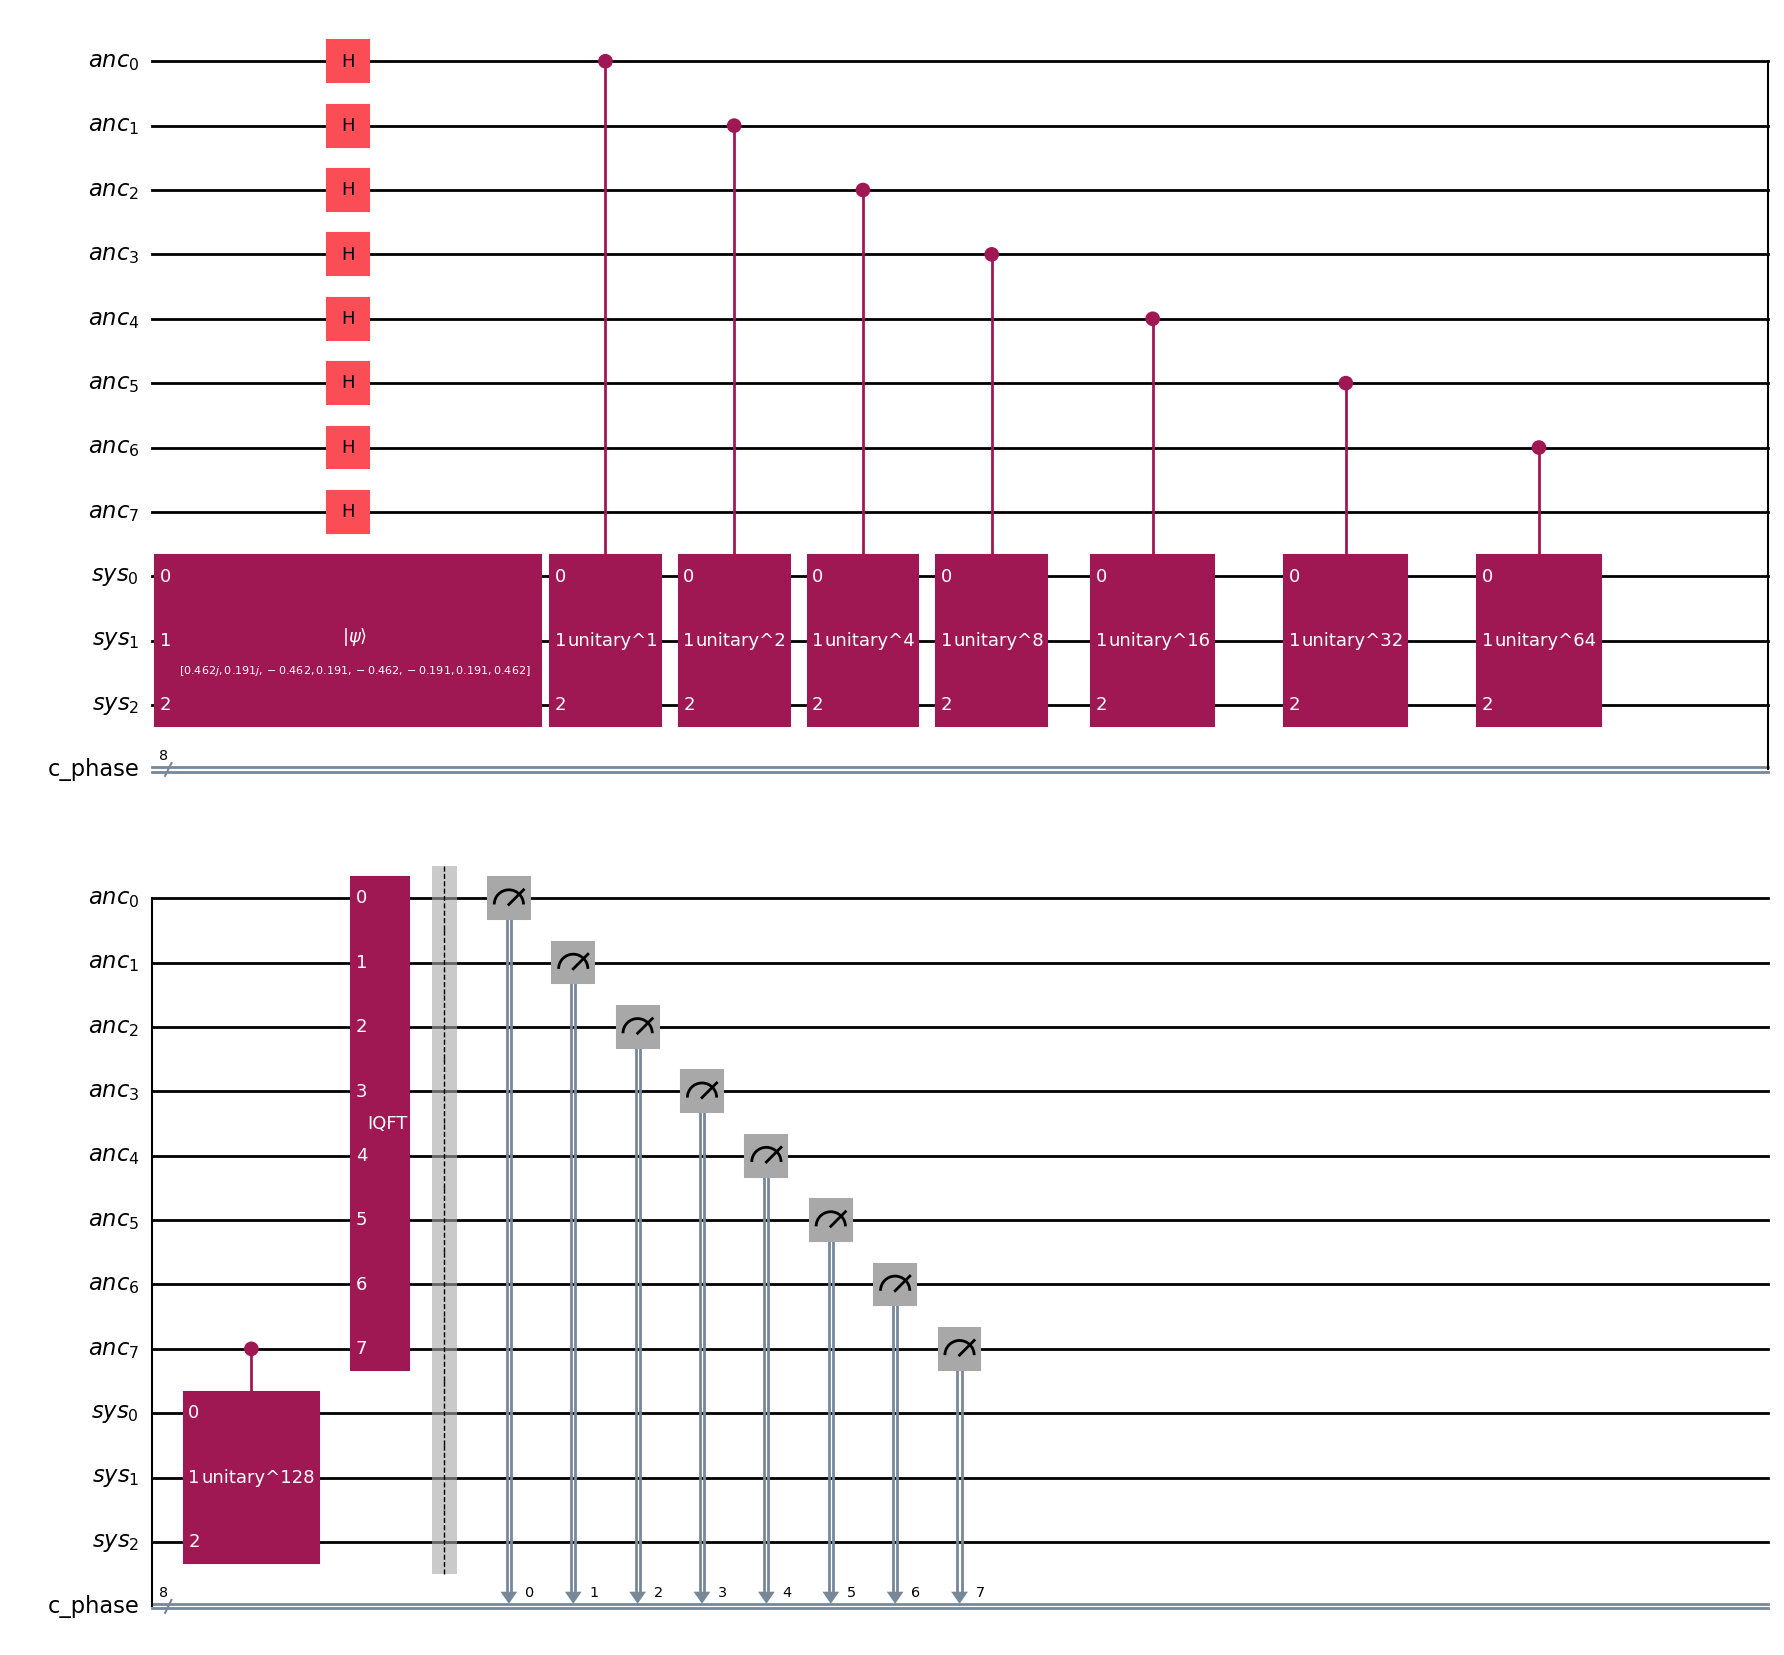

t=8 ancilla -> top bitstring 00010000 (phase=0.062500, prob=1.000)  error=0.000000
  00010000 -> 0.062500  count=4096  p=1.000
-------------------------------------------------------
Done. Ancilla qubits always mapped to their own classical bits (c_phase). System qubits unmeasured.


In [65]:
# Original
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
#from qiskit.circuit.library import QFT as QFTGate, UnitaryGate
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis.qft import synth_qft_full as QFT
from qiskit_aer import Aer
from qiskit import transpile
from IPython.display import display
import numpy as np

backend = Aer.get_backend('qasm_simulator')
shots = 4096

# Reuse previously defined U (unitary) and eigenvector
assert 'U' in globals(), "Run earlier cells to define the unitary U first."
assert 'eigenvector' in globals(), "Run the eigenvector derivation cell first."

# Ensure eigenvector normalized
eigenvector = np.array([-0. +0.46193977j, 0. +0.19134172j, -0.46193977-0.j, 0.19134172+0.j,
                        -0.46193977-0.j, -0.19134172-0.j, 0.19134172+0.j, 0.46193977+0.j])
_eig = eigenvector / np.linalg.norm(eigenvector)


def build_qpe(U_matrix, eigenstate, t):
    """Construct a QPE circuit with t phase (ancilla) qubits and a fixed 3‑qubit system register.
    Layout:
        ancilla register: anc[0] (LSB) ... anc[t-1] (MSB)
        system register: sys[0], sys[1], sys[2]
    Measurement: only ancilla -> classical c_phase.
    """
    anc = QuantumRegister(t, name='anc')
    sys = QuantumRegister(3, name='sys')
    c_phase = ClassicalRegister(t, name='c_phase')
    qc = QuantumCircuit(anc, sys, c_phase, name=f'QPE_t{t}')

    # 1. Prepare eigenstate on system register
    qc.initialize(eigenstate, sys)

    # 2. Put ancilla into superposition
    for k in range(t):
        qc.h(anc[k])

    # 3. Controlled U^{2^k}
    base = UnitaryGate(U_matrix, label='U')
    for k in range(t):
        power_gate = base.power(2**k).control(1)
        qc.append(power_gate, [anc[k]] + list(sys))

    # 4. Inverse QFT on ancilla using QFTGate (alias of QFT)
    iqft = QFT(num_qubits=t, inverse=True, do_swaps=True, insert_barriers=False).to_gate(label='IQFT')
    qc.append(iqft, anc)

    # 5. Measure ancilla only
    qc.barrier()
    qc.measure(anc, c_phase)
    return qc



def decode_counts(counts, t):
    """Decode phase estimates from counts dict: keys are bitstrings (MSB left)."""
    out = []
    for bitstring, c in counts.items():
        # bitstring returned left->right = anc[t-1] ... anc[0] due to swaps in IQFT
        decimal = int(bitstring, 2)
        phase = decimal / (2**t)
        out.append((bitstring, phase, c))
    out.sort(key=lambda x: x[2], reverse=True)
    return out

# Set expected_phase to 1/16 (from eigenvalue analysis)
expected_phase = 1/16
print(f"Expected phase decimal = {expected_phase:.6f}\n")

for t in [2, 4, 6, 8]:
    qc_qpe = build_qpe(U, _eig, t)
    # Show the circuit diagram (draw before transpile so it's readable)
    print(f"\nCircuit diagram for t={t} ancilla qubits:")
    display(qc_qpe.draw('mpl'))
    tqc = transpile(qc_qpe, backend, optimization_level=1)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()
    decoded = decode_counts(counts, t)
    top = decoded[0]
    print(f"t={t} ancilla -> top bitstring {top[0]} (phase={top[1]:.6f}, prob={top[2]/shots:.3f})  error={abs(top[1]-expected_phase):.6f}")
    # Show a compact histogram-style listing (top 6)
    for bit, ph, c in decoded[:6]:
        print(f"  {bit} -> {ph:.6f}  count={c}  p={c/shots:.3f}")
    print('-'*55)

print("Done. Ancilla qubits always mapped to their own classical bits (c_phase). System qubits unmeasured.")



=== t = 2 ancilla qubits ===
Circuit diagram: (skipped)


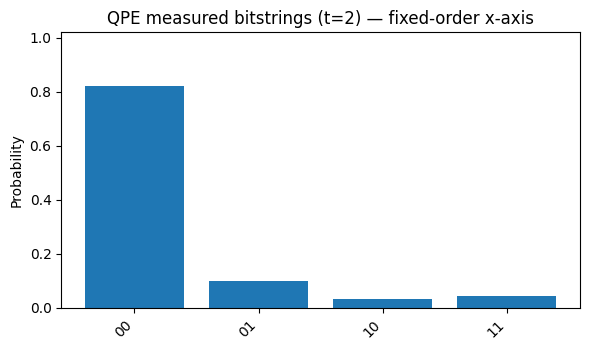


=== t = 4 ancilla qubits ===
Circuit diagram: (skipped)


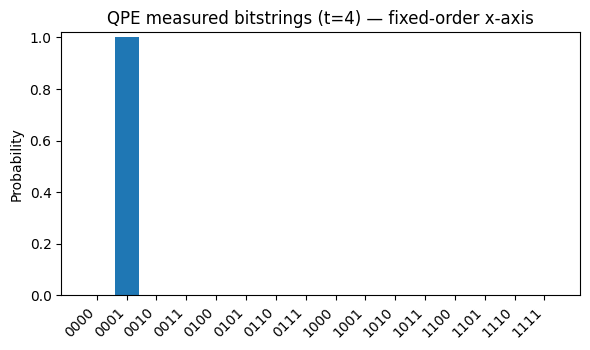


=== t = 6 ancilla qubits ===
Circuit diagram: (skipped)


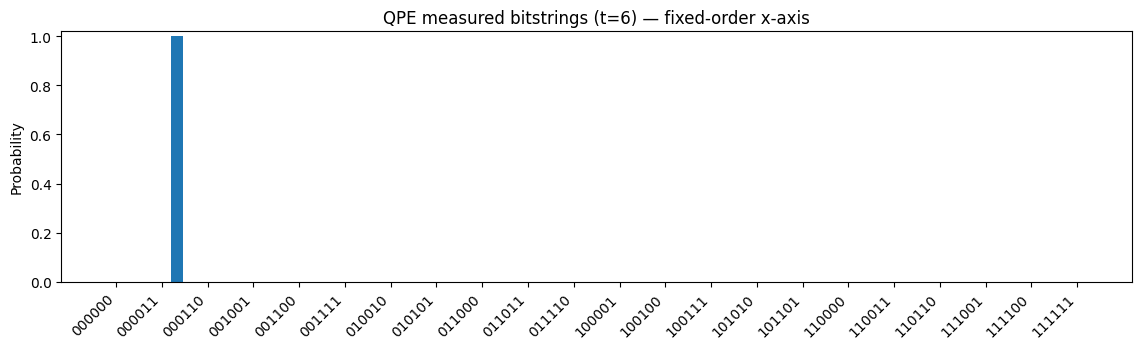


=== t = 8 ancilla qubits ===
Circuit diagram: (skipped)


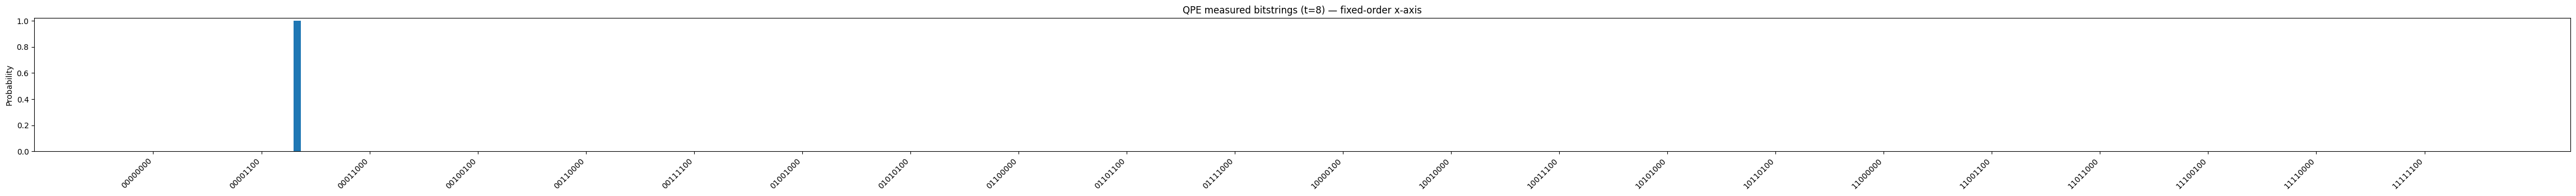

,top_bitstring,top_phase_decimal,top_prob,mean_phase,abs_error_mean,entropy_bits,distinct_outcomes
t,,,,,,,
2,00,0.0000,0.822021,0.075256,0.012756,0.928046,4
4,0001,0.0625,1.000000,0.062500,0.000000,-0.000000,1
6,000100,0.0625,1.000000,0.062500,0.000000,-0.000000,1
8,00010000,0.0625,1.000000,0.062500,0.000000,-0.000000,1



Interpretation:
The phase we expect is 0.0625 (decimal) — corresponding binary fraction (8-bit truncation): 0.00010000 (truncated).

Observations:
- For small t (e.g. t=2) the available grid of representable fractions is coarse. The QPE output spreads probability over the nearest representable values (higher entropy, several distinct outcomes).
- As t increases the grid resolution improves (steps of 1/2^t). Because the expected phase here is 1/16 = 0.0001₂, it is exactly representable on a t-bit grid when t ≥ 4. In an ideal simulator with exact eigenstate preparation you should therefore see the distribution concentrate on a single bitstring (top_prob → 1 and entropy → 0) for t ≥ 4.
- The mean_phase and abs_error_mean quantify how close the measured distribution is to the true phase; entropy quantifies spread. You should see abs_error_mean decrease and entropy fall as t increases when the phase aligns with the grid.

Notes:
- These results assume an ideal (noise-free) simulator and ex

In [66]:
# Analysis: accuracy and spread vs t
import math
import matplotlib.pyplot as plt
from IPython.display import display

# Optional pandas for a neat table
try:
    import pandas as pd
    _HAS_PANDAS = True
except Exception:
    _HAS_PANDAS = False

# Preconditions
assert 'build_qpe' in globals(), "Please run the cell that defines build_qpe() before this analysis."
assert 'decode_counts' in globals(), "Please run the cell that defines decode_counts() before this analysis."
assert 'U' in globals() and '_eig' in globals(), "Unitary U and eigenstate _eig must be defined by previous cells."

# Fallbacks
backend_local = globals().get('backend')
if backend_local is None:
    from qiskit_aer import Aer
    backend_local = Aer.get_backend('qasm_simulator')
shots_local = globals().get('shots', 4096)

# Use expected phase from cell 16's data (1/16)
expected_phase = globals().get('expected_phase', 1/16)

ts = [2, 4, 6, 8]
summary = []

for t in ts:
    print(f"\n=== t = {t} ancilla qubits ===")
    qc = build_qpe(U, _eig, t)

    # circuit drawing intentionally skipped in this analysis cell
    print("Circuit diagram: (skipped)")

    tqc = transpile(qc, backend_local, optimization_level=1)
    result = backend_local.run(tqc, shots=shots_local).result()
    counts = result.get_counts()

    # Build ordered labels (0..2^t-1) so x-axis is fixed from 00... to 11...
    ordered_labels = [format(i, f'0{t}b') for i in range(2**t)]
    counts_map = {k: v for k, v in counts.items()}
    labels = ordered_labels
    probs = [counts_map.get(lb, 0) / shots_local for lb in labels]
    # Phases corresponding to the ordered labels
    phases = [int(lb, 2) / (2**t) for lb in labels]

    # Plot histogram (all outcomes in fixed order; limit ticks for readability)
    topN = len(labels)
    plt.figure(figsize=(max(6, topN*0.18), 3.6))
    plt.bar(range(topN), probs, color='C0')
    # show only up to 40 tick labels for readability when t large
    if topN <= 40:
        plt.xticks(range(topN), labels, rotation=45, ha='right')
    else:
        # select a subset of ticks evenly
        step = max(1, topN // 20)
        plt.xticks(range(0, topN, step), [labels[i] for i in range(0, topN, step)], rotation=45, ha='right')
    plt.ylim(0, 1.02)
    plt.ylabel('Probability')
    plt.title(f'QPE measured bitstrings (t={t}) — fixed-order x-axis')
    plt.tight_layout()
    plt.show()

    # Metrics (top outcome still taken from decoded sorted-by-count list)
    decoded = decode_counts(counts, t)
    top_bit, top_phase, top_count = decoded[0]
    top_prob = top_count / shots_local
    # weighted (mean) phase using ordered probs and phases
    mean_phase = sum(p * ph for p, ph in zip(probs, phases))
    # L1 error of mean to expected
    abs_error = abs(mean_phase - expected_phase)
    # Shannon entropy of the measured distribution
    entropy = -sum(p * math.log2(p) for p in probs if p > 0)

    summary.append({
        't': t,
        'top_bitstring': top_bit,
        'top_phase_decimal': top_phase,
        'top_prob': round(top_prob, 6),
        'mean_phase': mean_phase,
        'abs_error_mean': abs_error,
        'entropy_bits': entropy,
        'distinct_outcomes': len([p for p in probs if p > 0])
    })

# Present results as a table
if _HAS_PANDAS:
    df = pd.DataFrame(summary).set_index('t')
    display(df)
else:
    print("\nSummary table:")
    for row in summary:
        print(f"t={row['t']}: top={row['top_bitstring']} phase={row['top_phase_decimal']:.6f} top_p={row['top_prob']:.4f} mean_phase={row['mean_phase']:.6f} abs_err_mean={row['abs_error_mean']:.6f} entropy={row['entropy_bits']:.4f} outcomes={row['distinct_outcomes']}")

# Short interpretation paragraph (updated for expected phase 1/16)
print('\nInterpretation:')
print('The phase we expect is', expected_phase, '(decimal) — corresponding binary fraction (8-bit truncation): 0.' + format(int(expected_phase * (2**8)), '08b') + ' (truncated).')
print('')
print('Observations:')
print('- For small t (e.g. t=2) the available grid of representable fractions is coarse. The QPE output spreads probability over the nearest representable values (higher entropy, several distinct outcomes).')
print('- As t increases the grid resolution improves (steps of 1/2^t). Because the expected phase here is 1/16 = 0.0001₂, it is exactly representable on a t-bit grid when t ≥ 4. In an ideal simulator with exact eigenstate preparation you should therefore see the distribution concentrate on a single bitstring (top_prob → 1 and entropy → 0) for t ≥ 4.')
print('- The mean_phase and abs_error_mean quantify how close the measured distribution is to the true phase; entropy quantifies spread. You should see abs_error_mean decrease and entropy fall as t increases when the phase aligns with the grid.')
print('\nNotes:')
print('- These results assume an ideal (noise-free) simulator and exact eigenstate preparation. On hardware or with imperfect preparation you will see broader distributions and slower concentration.')
print('- To see nontrivial spreads at larger t, choose a phase that is not a k/2^t rational or add noise/state-prep error.')


Expected phase decimal = 0.159623


Circuit diagram for t=2 ancilla qubits:


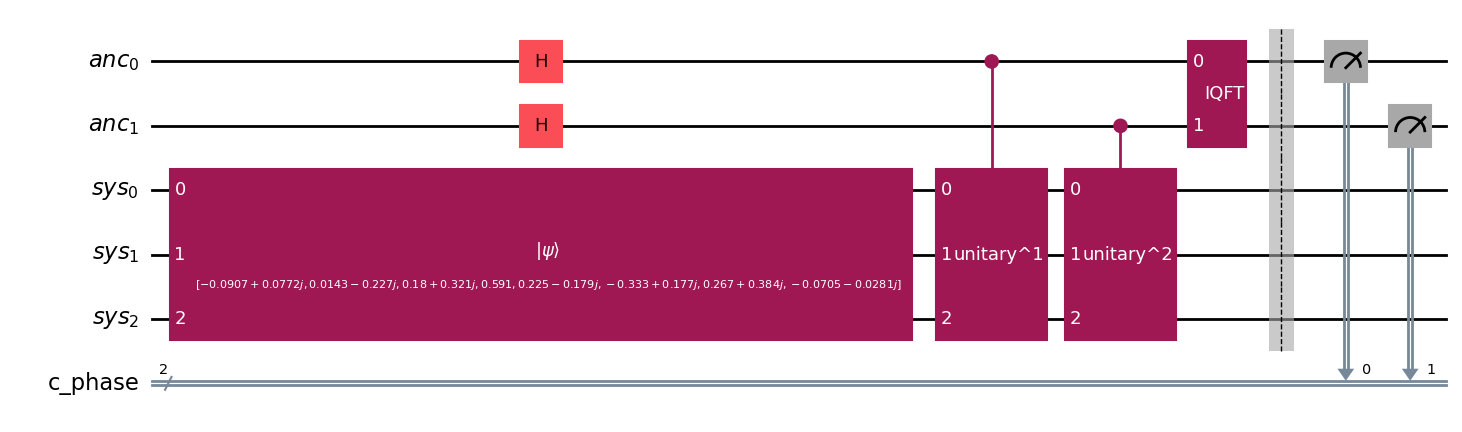

t=2 ancilla -> top bitstring 01 (phase=0.250000, prob=0.659)  error=0.090377
  01 -> 0.250000  count=2698  p=0.659
  00 -> 0.000000  count=927  p=0.226
  10 -> 0.500000  count=246  p=0.060
  11 -> 0.750000  count=225  p=0.055
-------------------------------------------------------

Circuit diagram for t=4 ancilla qubits:


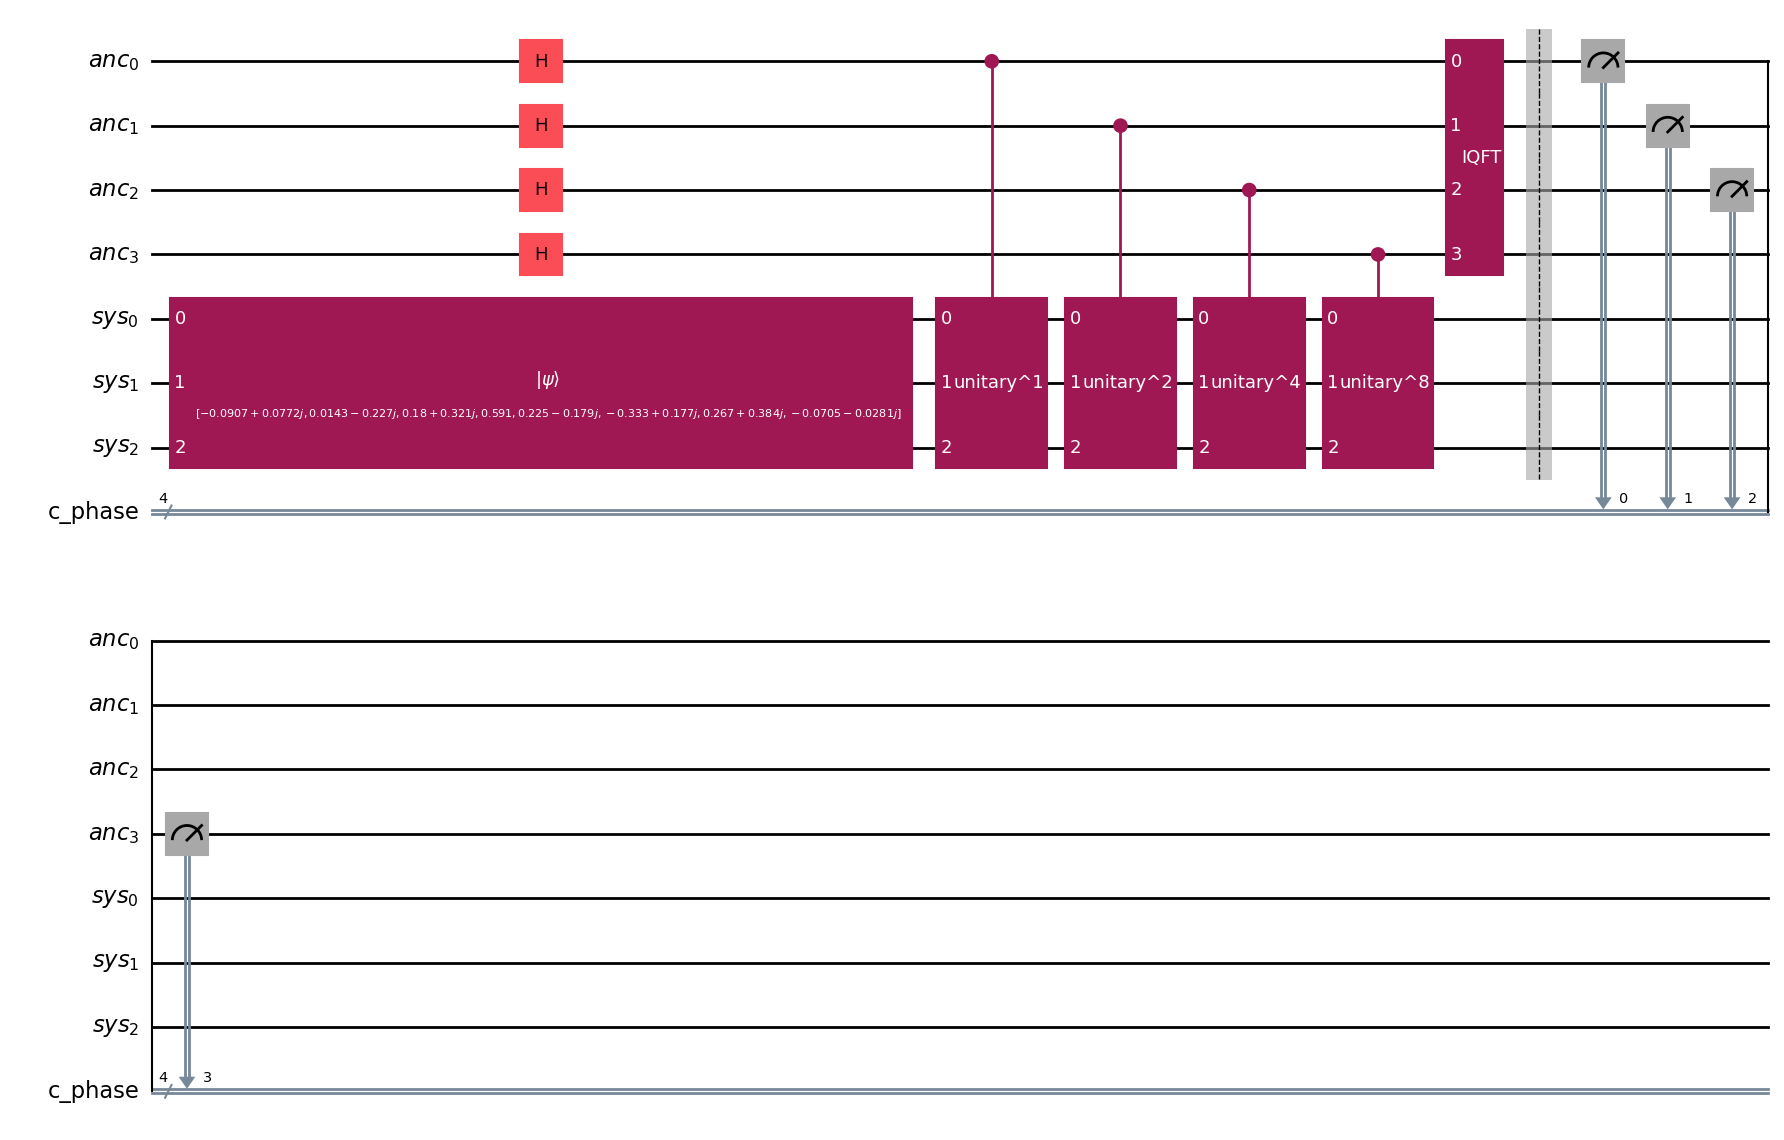

t=4 ancilla -> top bitstring 0011 (phase=0.187500, prob=0.497)  error=0.027877
  0011 -> 0.187500  count=2037  p=0.497
  0010 -> 0.125000  count=1336  p=0.326
  0100 -> 0.250000  count=185  p=0.045
  0001 -> 0.062500  count=160  p=0.039
  0000 -> 0.000000  count=84  p=0.021
  0101 -> 0.312500  count=75  p=0.018
-------------------------------------------------------

Circuit diagram for t=6 ancilla qubits:


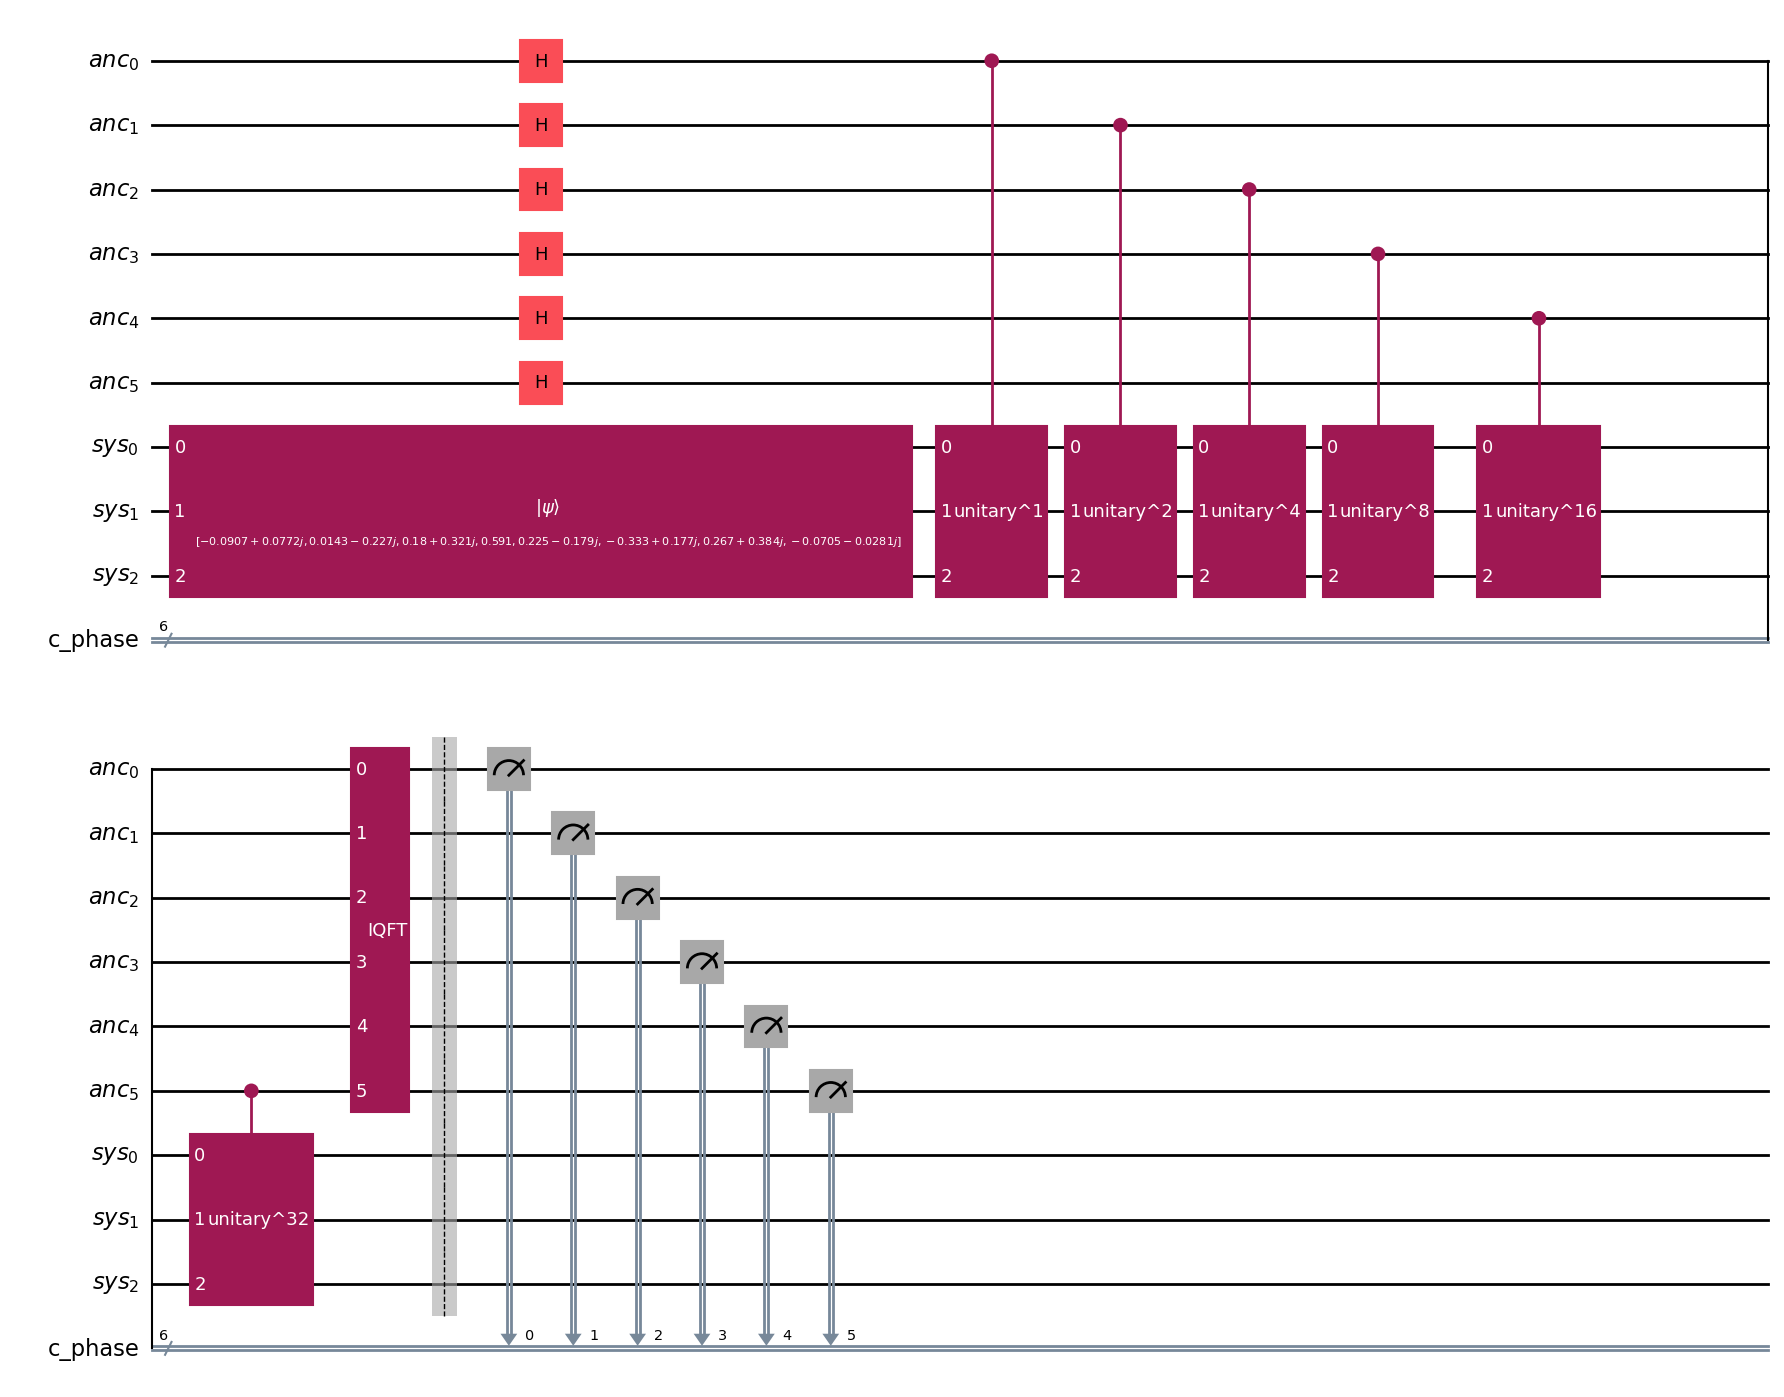

t=6 ancilla -> top bitstring 001010 (phase=0.156250, prob=0.854)  error=0.003373
  001010 -> 0.156250  count=3496  p=0.854
  001011 -> 0.171875  count=249  p=0.061
  001001 -> 0.140625  count=130  p=0.032
  001100 -> 0.187500  count=52  p=0.013
  001000 -> 0.125000  count=37  p=0.009
  001101 -> 0.203125  count=22  p=0.005
-------------------------------------------------------

Circuit diagram for t=8 ancilla qubits:


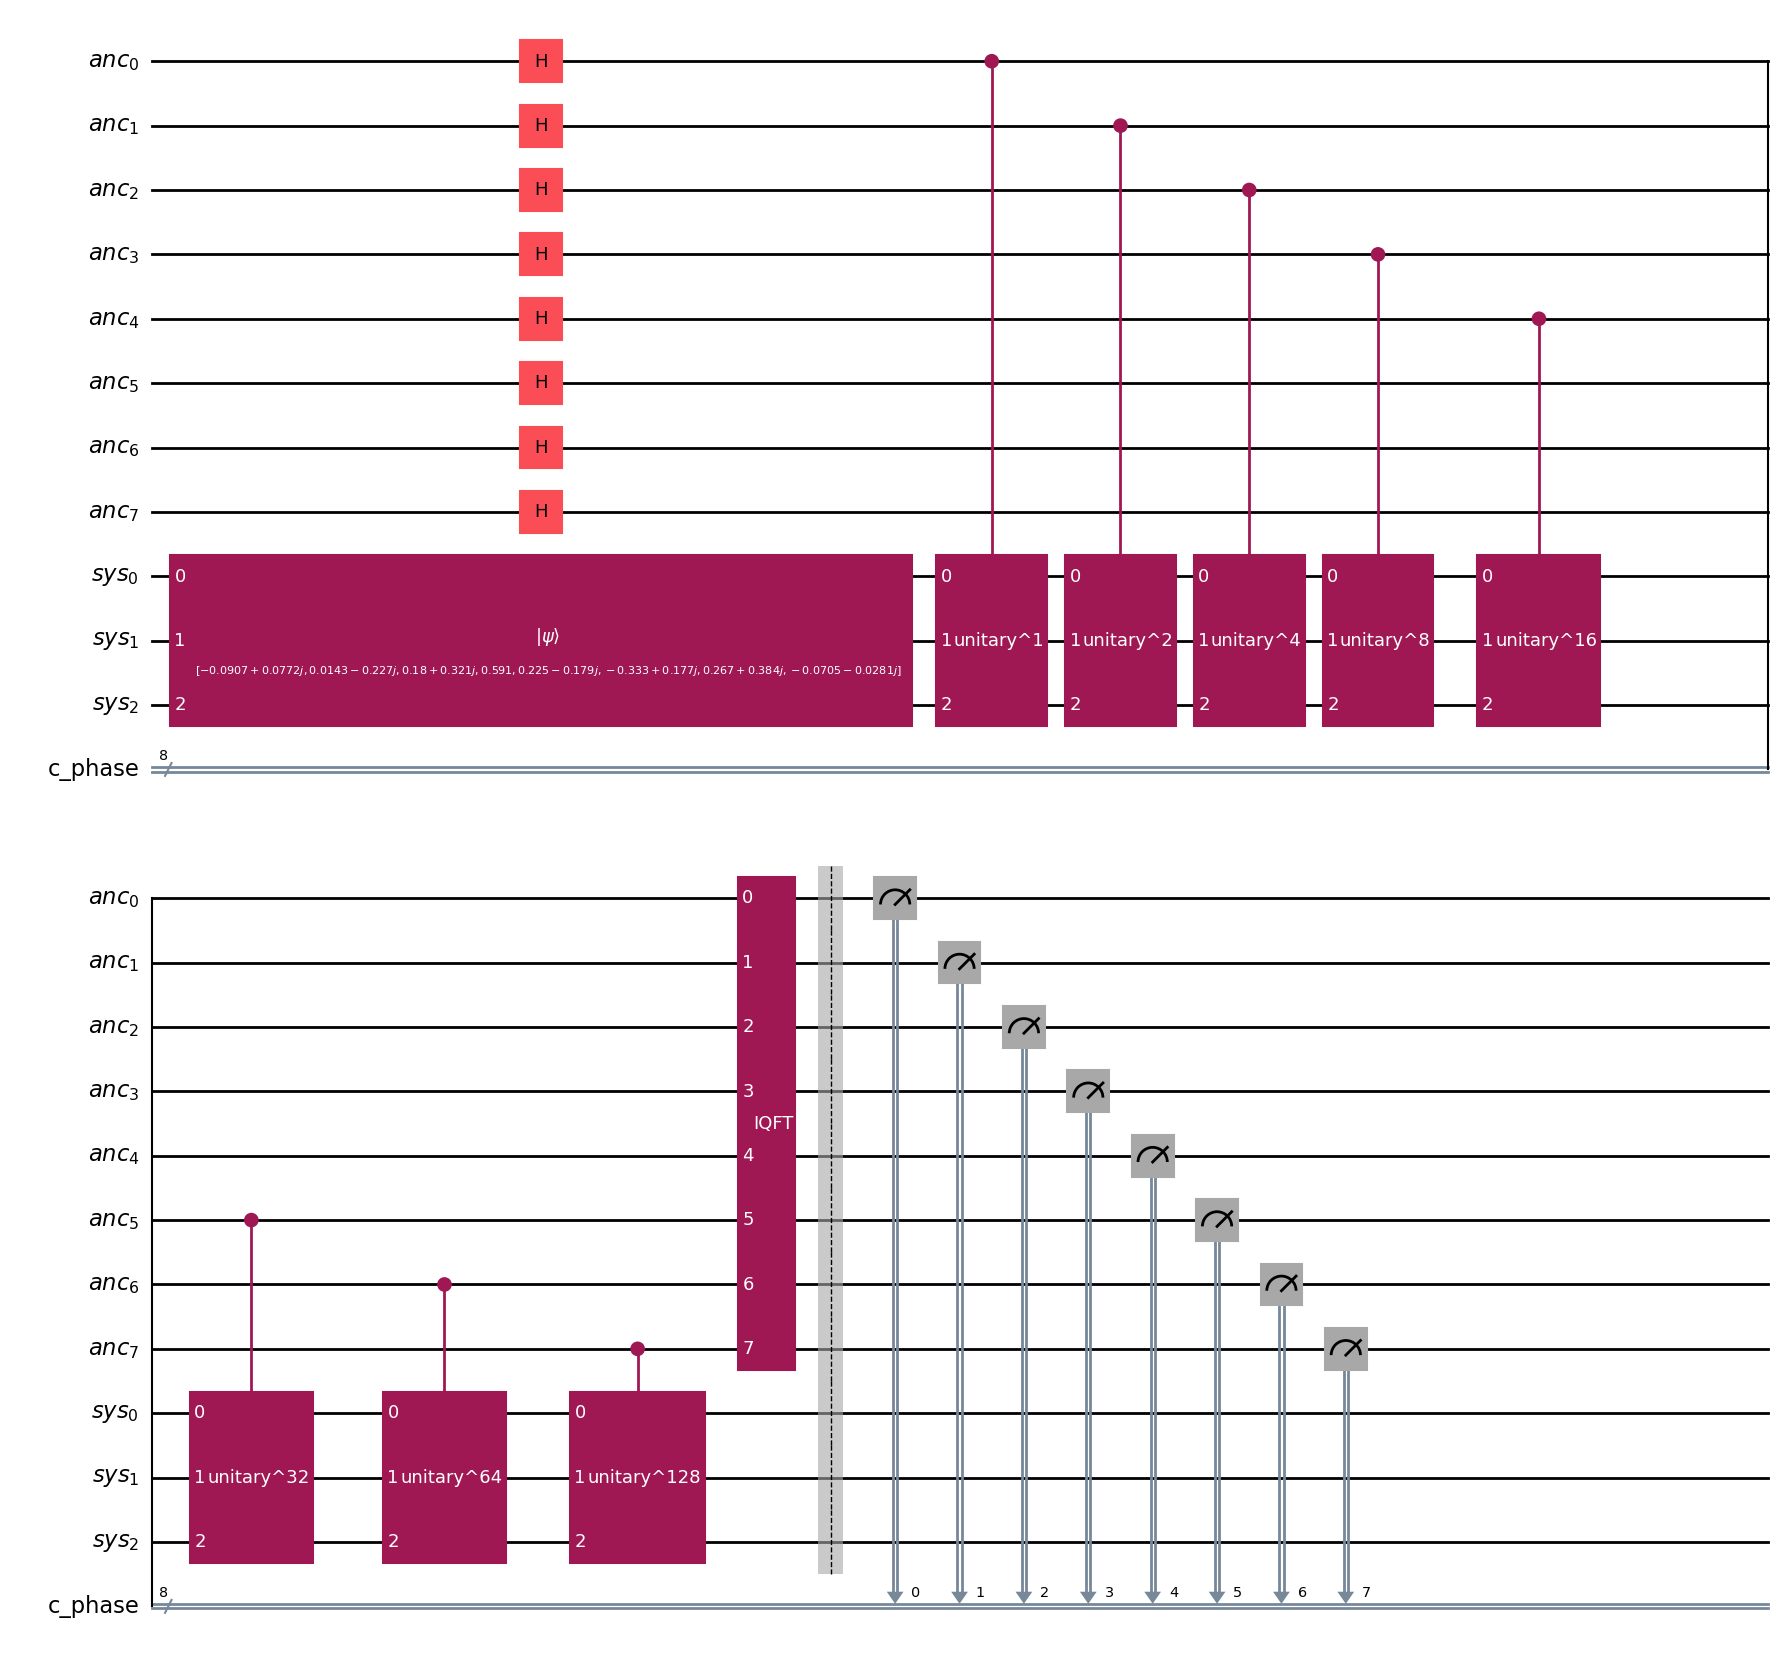

t=8 ancilla -> top bitstring 00101001 (phase=0.160156, prob=0.938)  error=0.000533
  00101001 -> 0.160156  count=3840  p=0.938
  00101000 -> 0.156250  count=87  p=0.021
  00101010 -> 0.164062  count=52  p=0.013
  00100111 -> 0.152344  count=24  p=0.006
  00101011 -> 0.167969  count=20  p=0.005
  00100110 -> 0.148438  count=11  p=0.003
-------------------------------------------------------
Done. Ancilla qubits always mapped to their own classical bits (c_phase). System qubits unmeasured.


In [67]:
# Experimental

backend = Aer.get_backend('qasm_simulator')
shots = 4096

# Reuse previously defined U (unitary) and eigenvector
assert 'U' in globals(), "Run earlier cells to define the unitary U first."
assert 'eigenvector' in globals(), "Run the eigenvector derivation cell first."

# Ensure eigenvector normalized
eigenvector = np.array([-0.09074869+0.07724145j,  0.01426988-0.22742176j,  0.18045285+0.32112435j,
  0.59063246+0.j          ,  0.22530406-0.17872043j, -0.33257214+0.17710038j,
  0.26743148+0.3839239j  , -0.07046097-0.02810309j])
_eig = eigenvector / np.linalg.norm(eigenvector)


def build_qpe(U_matrix, eigenstate, t):
    """Construct a QPE circuit with t phase (ancilla) qubits and a fixed 3‑qubit system register.
    Layout:
        ancilla register: anc[0] (LSB) ... anc[t-1] (MSB)
        system register: sys[0], sys[1], sys[2]
    Measurement: only ancilla -> classical c_phase.
    """
    anc = QuantumRegister(t, name='anc')
    sys = QuantumRegister(3, name='sys')
    c_phase = ClassicalRegister(t, name='c_phase')
    qc = QuantumCircuit(anc, sys, c_phase, name=f'QPE_t{t}')

    # 1. Prepare eigenstate on system register
    qc.initialize(eigenstate, sys)

    # 2. Put ancilla into superposition
    for k in range(t):
        qc.h(anc[k])

    # 3. Controlled U^{2^k}
    base = UnitaryGate(U_matrix, label='U')
    for k in range(t):
        power_gate = base.power(2**k).control(1)
        qc.append(power_gate, [anc[k]] + list(sys))

    # 4. Inverse QFT on ancilla using QFTGate (alias of QFT)
    iqft = QFT(num_qubits=t, inverse=True, do_swaps=True, insert_barriers=False).to_gate(label='IQFT')
    qc.append(iqft, anc)

    # 5. Measure ancilla only
    qc.barrier()
    qc.measure(anc, c_phase)
    return qc


def decode_counts(counts, t):
    """Decode phase estimates from counts dict: keys are bitstrings (MSB left)."""
    out = []
    for bitstring, c in counts.items():
        # bitstring returned left->right = anc[t-1] ... anc[0] due to swaps in IQFT
        decimal = int(bitstring, 2)
        phase = decimal / (2**t)
        out.append((bitstring, phase, c))
    out.sort(key=lambda x: x[2], reverse=True)
    return out

expected_phase = 0.15962346375  # from eigenvalue calculation
print(f"Expected phase decimal = {expected_phase:.6f}\n")

for t in [2, 4, 6, 8]:
    qc_qpe = build_qpe(U, _eig, t)
    # Show the circuit diagram (draw before transpile so it's readable)
    print(f"\nCircuit diagram for t={t} ancilla qubits:")
    display(qc_qpe.draw('mpl'))
    tqc = transpile(qc_qpe, backend, optimization_level=1)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()
    decoded = decode_counts(counts, t)
    top = decoded[0]
    print(f"t={t} ancilla -> top bitstring {top[0]} (phase={top[1]:.6f}, prob={top[2]/shots:.3f})  error={abs(top[1]-expected_phase):.6f}")
    # Show a compact histogram-style listing (top 6)
    for bit, ph, c in decoded[:6]:
        print(f"  {bit} -> {ph:.6f}  count={c}  p={c/shots:.3f}")
    print('-'*55)

print("Done. Ancilla qubits always mapped to their own classical bits (c_phase). System qubits unmeasured.")



=== t = 2 ancilla qubits ===
Circuit diagram: (skipped)


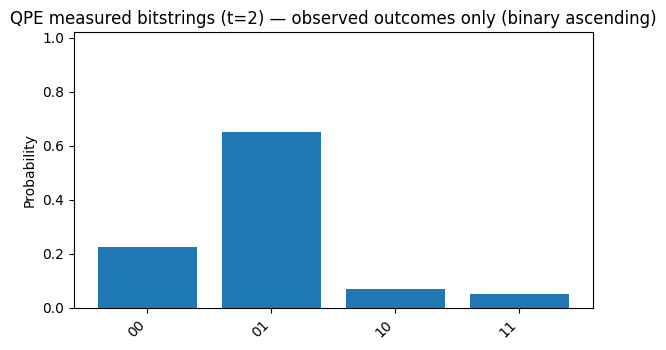


=== t = 4 ancilla qubits ===
Circuit diagram: (skipped)


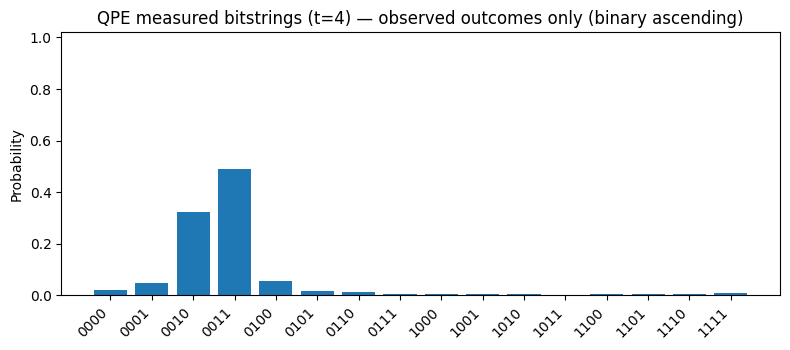


=== t = 6 ancilla qubits ===
Circuit diagram: (skipped)


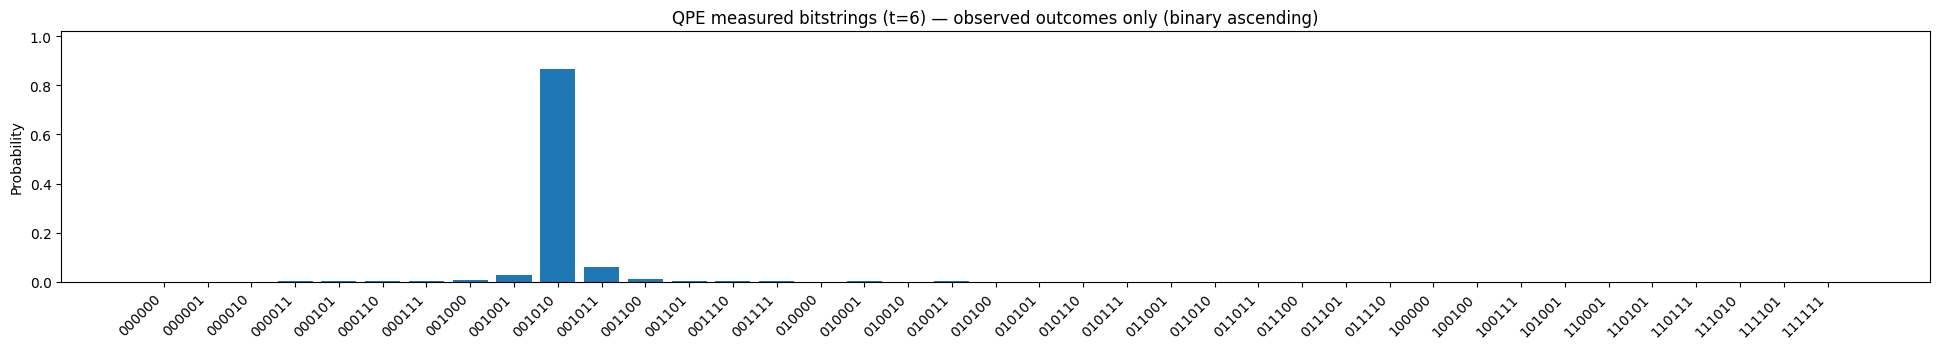


=== t = 8 ancilla qubits ===
Circuit diagram: (skipped)
Circuit diagram: (skipped)


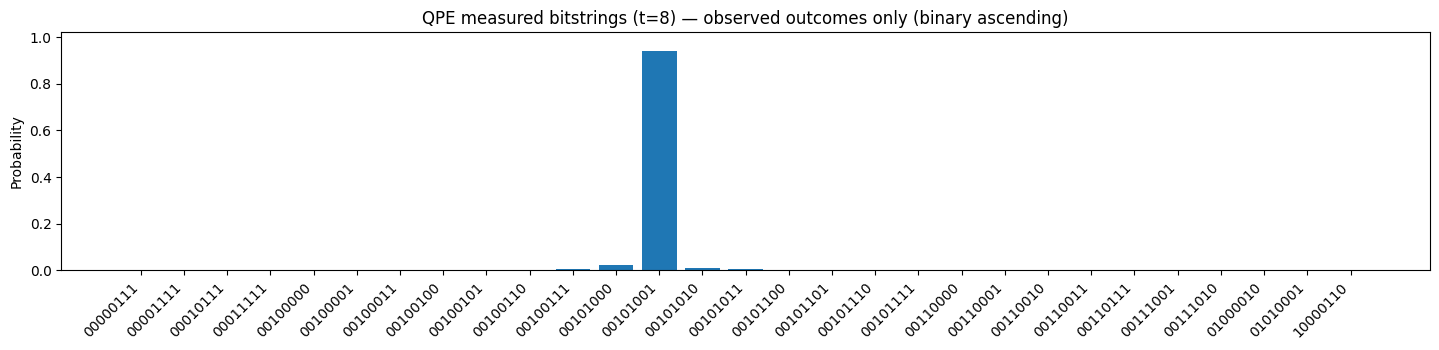

,top_bitstring,top_phase_decimal,top_prob,mean_phase,abs_error_mean,entropy_bits,distinct_outcomes
t,,,,,,,
2,01,0.250000,0.652100,0.236938,0.077315,1.377135,4
4,0011,0.187500,0.489014,0.188248,0.028624,2.073393,16
6,001010,0.156250,0.867188,0.159626,0.000003,0.952916,39
8,00101001,0.160156,0.941406,0.160246,0.000622,0.495620,29


In [69]:
# Analysis: accuracy and spread vs t
import math
import matplotlib.pyplot as plt
from IPython.display import display

# Optional pandas for a neat table
try:
    import pandas as pd
    _HAS_PANDAS = True
except Exception:
    _HAS_PANDAS = False

# Preconditions
assert 'build_qpe' in globals(), "Please run the cell that defines build_qpe() before this analysis." 
assert 'decode_counts' in globals(), "Please run the cell that defines decode_counts() before this analysis." 
assert 'U' in globals() and '_eig' in globals(), "Unitary U and eigenstate _eig must be defined by previous cells." 

# Fallbacks
backend_local = globals().get('backend')
if backend_local is None:
    from qiskit_aer import Aer
    backend_local = Aer.get_backend('qasm_simulator')
shots_local = globals().get('shots', 4096)

# Use expected numeric phase value (from eigenvalue calculation)
expected_phase = globals().get('expected_phase', 0.15962346375)  # from eigenvalue calculation

ts = [2, 4, 6, 8]
summary = []

for t in ts:
    print(f"\n=== t = {t} ancilla qubits ===")
    qc = build_qpe(U, _eig, t)

    # circuit drawing intentionally skipped in this analysis cell
    print("Circuit diagram: (skipped)")

    tqc = transpile(qc, backend_local, optimization_level=1)
    result = backend_local.run(tqc, shots=shots_local).result()
    counts = result.get_counts()

    # Build counts_by_decimal to avoid bit-order ambiguity and ensure fixed binary ascending order
    counts_by_decimal = {}
    for k, v in counts.items():
        k_clean = k.replace(' ', '')
        try:
            idx = int(k_clean, 2)
        except Exception:
            idx = int(k, 2)
        counts_by_decimal[idx] = v

    # Full labels (all possible bitstrings in ascending binary order)
    labels_all = [format(i, f'0{t}b') for i in range(2**t)]
    probs_all = [counts_by_decimal.get(i, 0) / shots_local for i in range(2**t)]
    phases_all = [i / (2**t) for i in range(2**t)]

    # For plotting: filter out zero-probability outcomes so x-axis contains only observed states
    nonzero_indices = [i for i, p in enumerate(probs_all) if p > 0]
    if len(nonzero_indices) == 0:
        # nothing observed (shouldn't happen with shots>0), fall back to showing all
        plot_indices = list(range(2**t))
    else:
        plot_indices = nonzero_indices

    labels_plot = [labels_all[i] for i in plot_indices]
    probs_plot = [probs_all[i] for i in plot_indices]

    # Plot histogram of only observed outcomes in ascending-binary order
    plt.figure(figsize=(max(6, len(labels_plot)*0.5), 3.6))
    x = range(len(labels_plot))
    plt.bar(x, probs_plot, color='C0')
    plt.xticks(x, labels_plot, rotation=45, ha='right')
    plt.ylim(0, 1.02)
    plt.ylabel('Probability')
    plt.title(f'QPE measured bitstrings (t={t}) — observed outcomes only (binary ascending)')
    plt.tight_layout()
    plt.show()

    # Metrics (top outcome still taken from decoded sorted-by-count list)
    decoded = decode_counts(counts, t)
    top_bit, top_phase, top_count = decoded[0]
    top_prob = top_count / shots_local
    mean_phase = sum(p * ph for p, ph in zip(probs_all, phases_all))
    abs_error = abs(mean_phase - expected_phase)
    # Shannon entropy of the measured distribution (only p>0 to avoid math domain error)
    entropy = -sum(p * math.log2(p) for p in probs_all if p > 0)

    summary.append({
        't': t,
        'top_bitstring': top_bit,
        'top_phase_decimal': top_phase,
        'top_prob': round(top_prob, 6),
        'mean_phase': mean_phase,
        'abs_error_mean': abs_error,
        'entropy_bits': entropy,
        'distinct_outcomes': len([p for p in probs_all if p > 0])
    })

# Present results as a table
if _HAS_PANDAS:
    df = pd.DataFrame(summary).set_index('t')
    display(df)
else:
    print("\nSummary table:")
    for row in summary:
        print(f"t={row['t']}: top={row['top_bitstring']} phase={row['top_phase_decimal']:.6f} top_p={row['top_prob']:.4f} mean_phase={row['mean_phase']:.6f} abs_err_mean={row['abs_error_mean']:.6f} entropy={row['entropy_bits']:.4f} outcomes={row['distinct_outcomes']}")


Expected phase decimal = 0.159623


Circuit diagram for t=2 ancilla qubits:


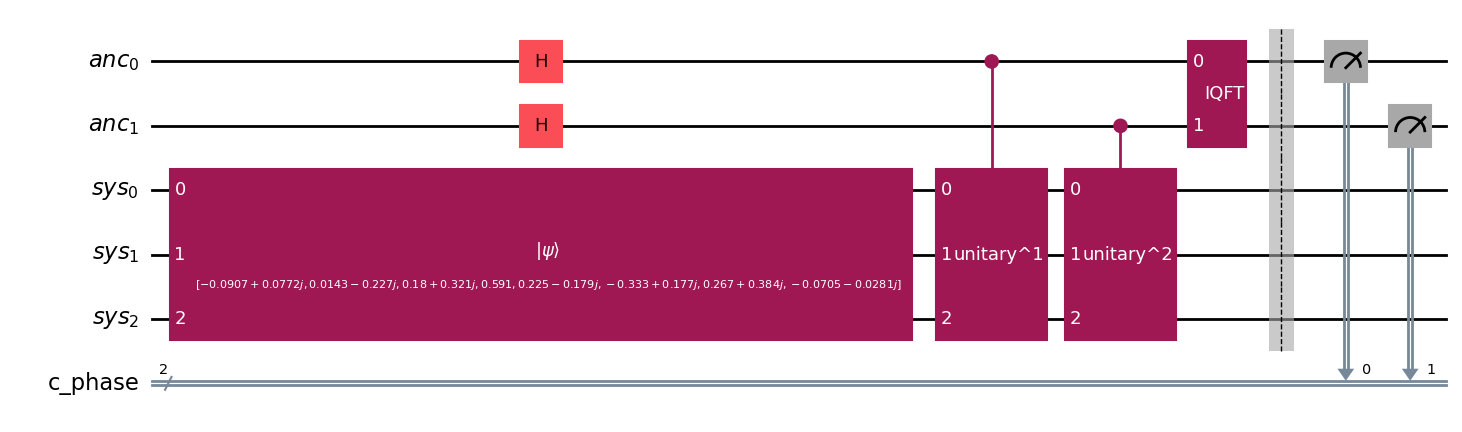

t=2 ancilla -> top bitstring 01 (phase=0.250000, prob=0.648)  error=0.090377


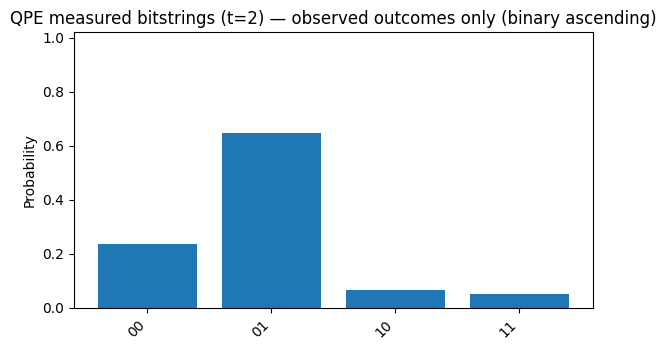

  01 -> 0.250000  count=2654  p=0.648
  00 -> 0.000000  count=962  p=0.235
  10 -> 0.500000  count=273  p=0.067
  11 -> 0.750000  count=207  p=0.051
-------------------------------------------------------

Circuit diagram for t=4 ancilla qubits:

Circuit diagram for t=4 ancilla qubits:


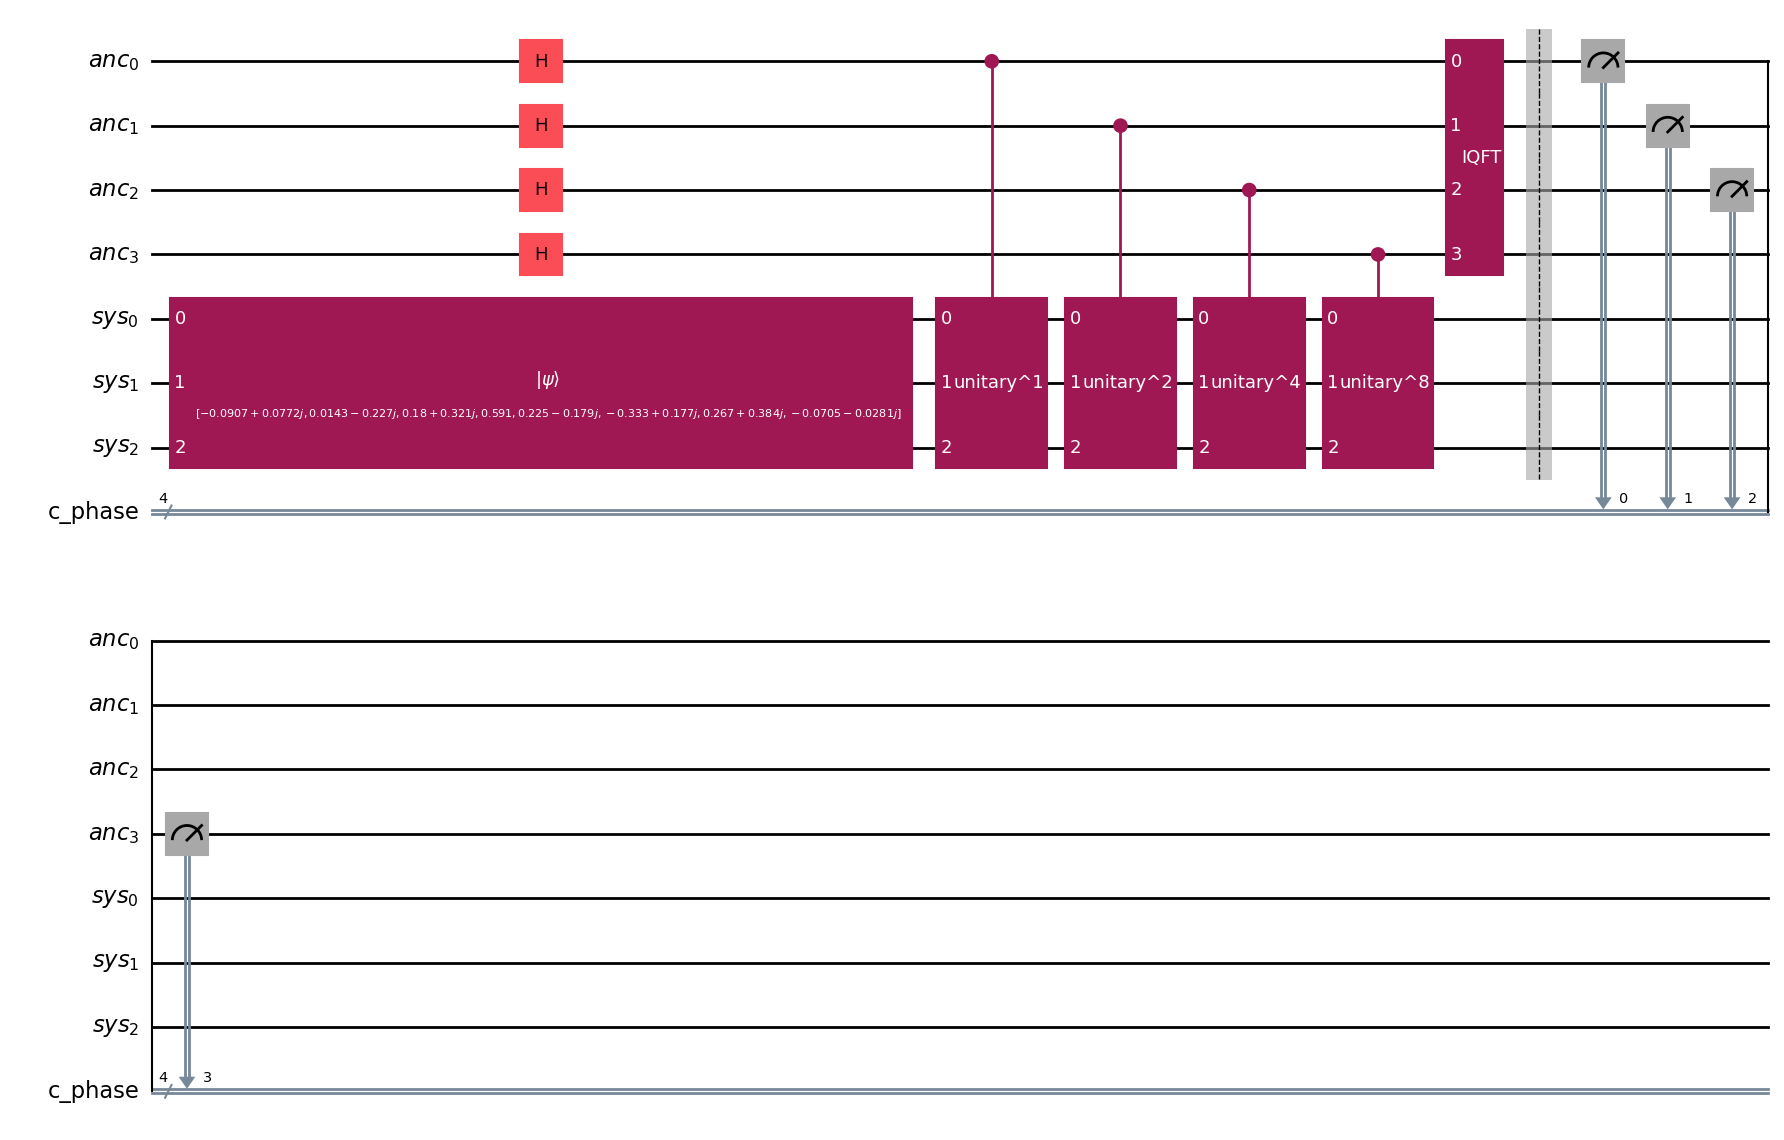

t=4 ancilla -> top bitstring 0011 (phase=0.187500, prob=0.496)  error=0.027877


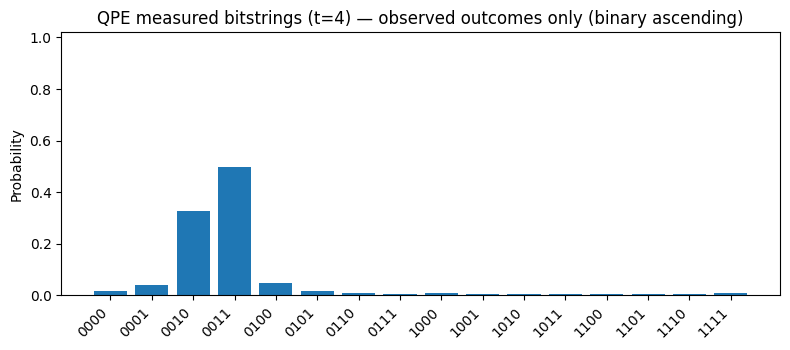

  0011 -> 0.187500  count=2031  p=0.496
  0010 -> 0.125000  count=1341  p=0.327
  0100 -> 0.250000  count=195  p=0.048
  0001 -> 0.062500  count=163  p=0.040
  0000 -> 0.000000  count=69  p=0.017
  0101 -> 0.312500  count=67  p=0.016
-------------------------------------------------------

Circuit diagram for t=6 ancilla qubits:

Circuit diagram for t=6 ancilla qubits:


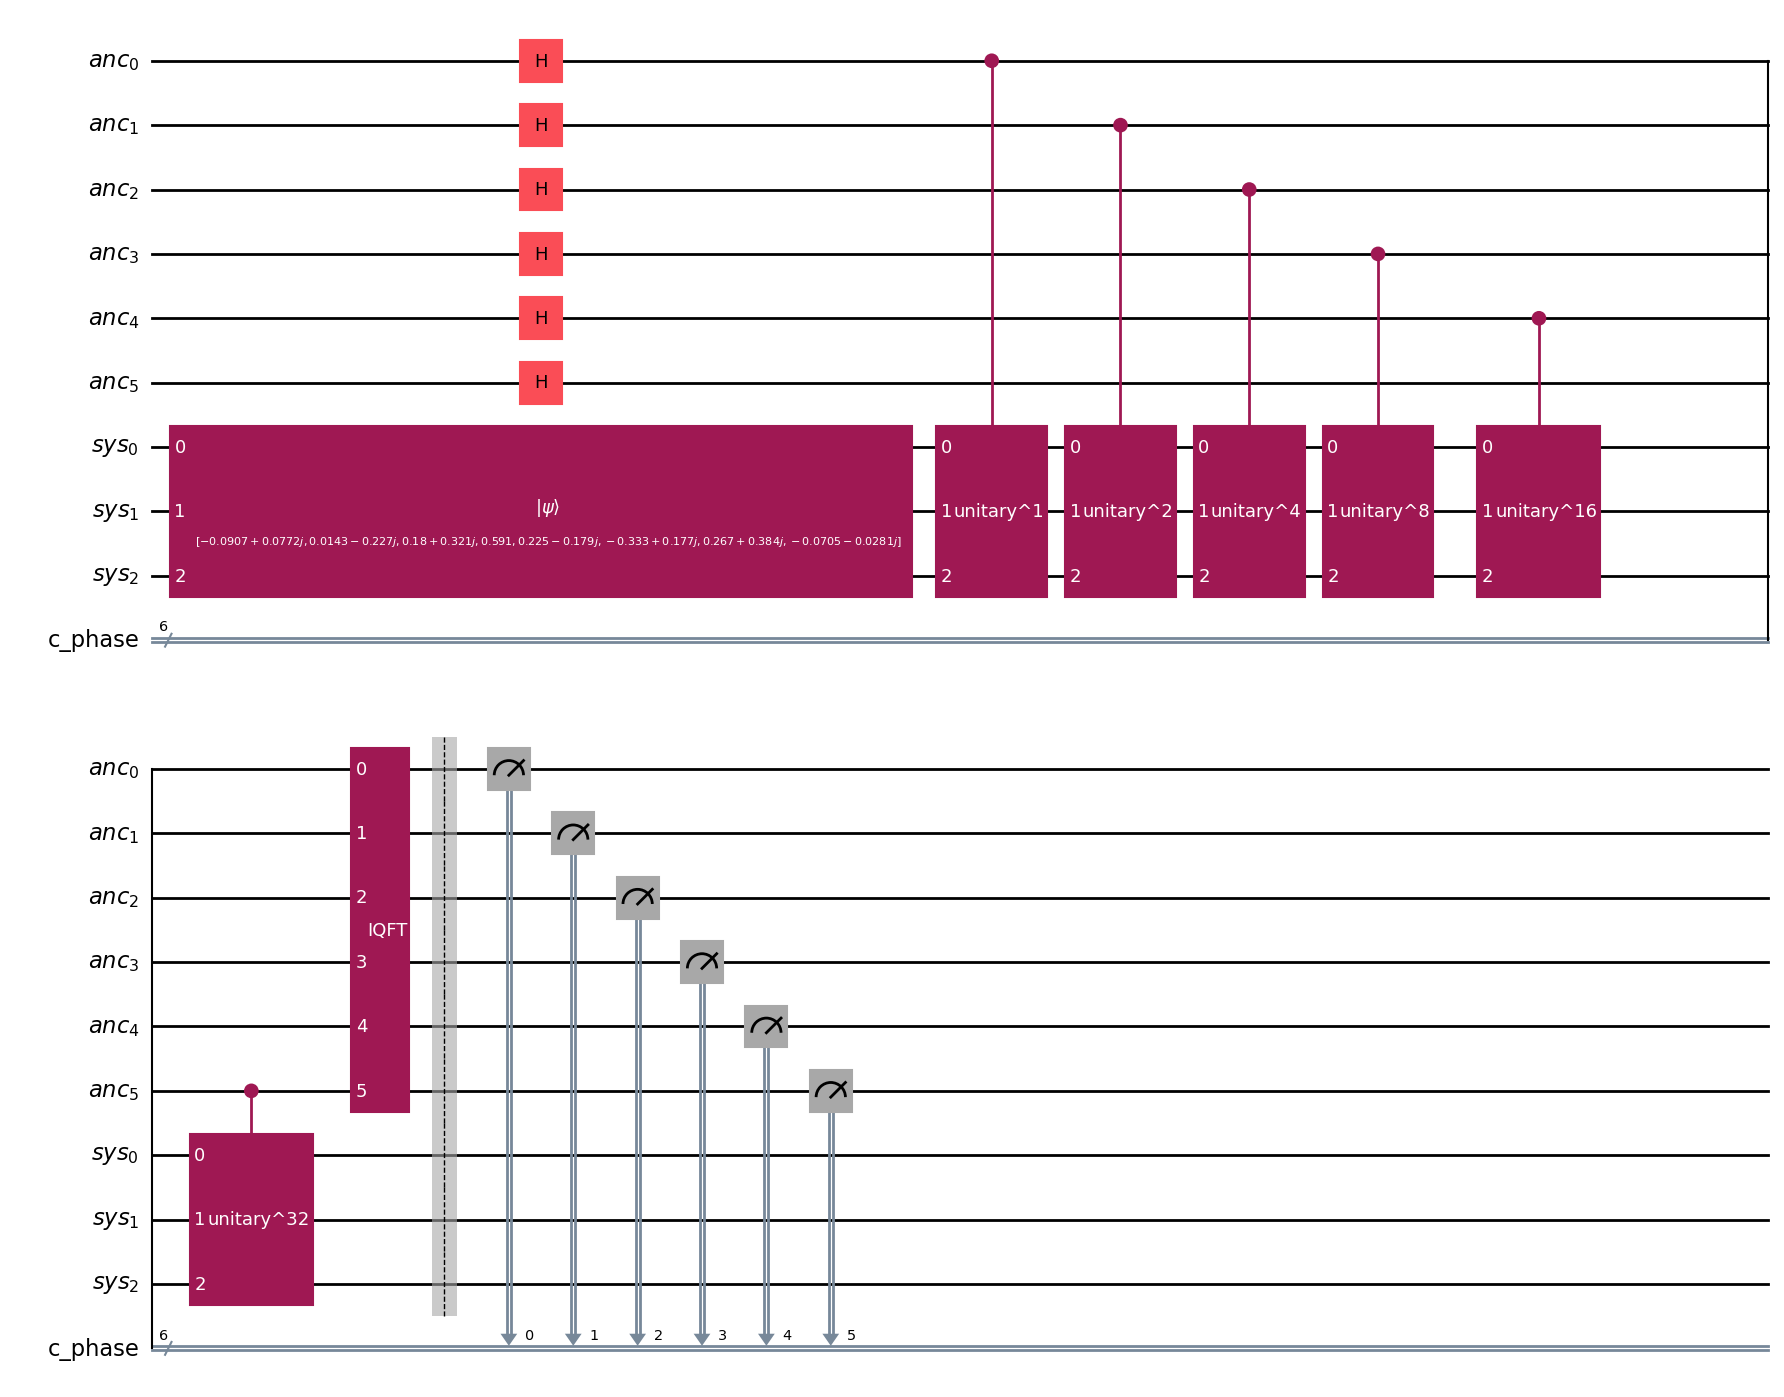

t=6 ancilla -> top bitstring 001010 (phase=0.156250, prob=0.858)  error=0.003373


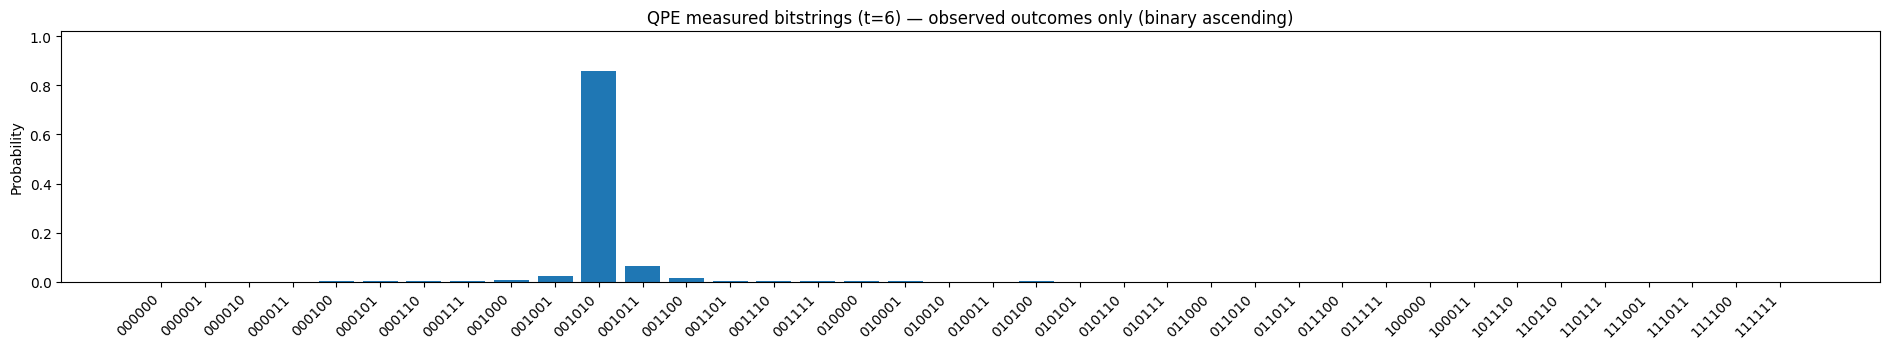

  001010 -> 0.156250  count=3516  p=0.858
  001011 -> 0.171875  count=267  p=0.065
  001001 -> 0.140625  count=101  p=0.025
  001100 -> 0.187500  count=65  p=0.016
  001000 -> 0.125000  count=26  p=0.006
  000111 -> 0.109375  count=17  p=0.004
-------------------------------------------------------

Circuit diagram for t=8 ancilla qubits:


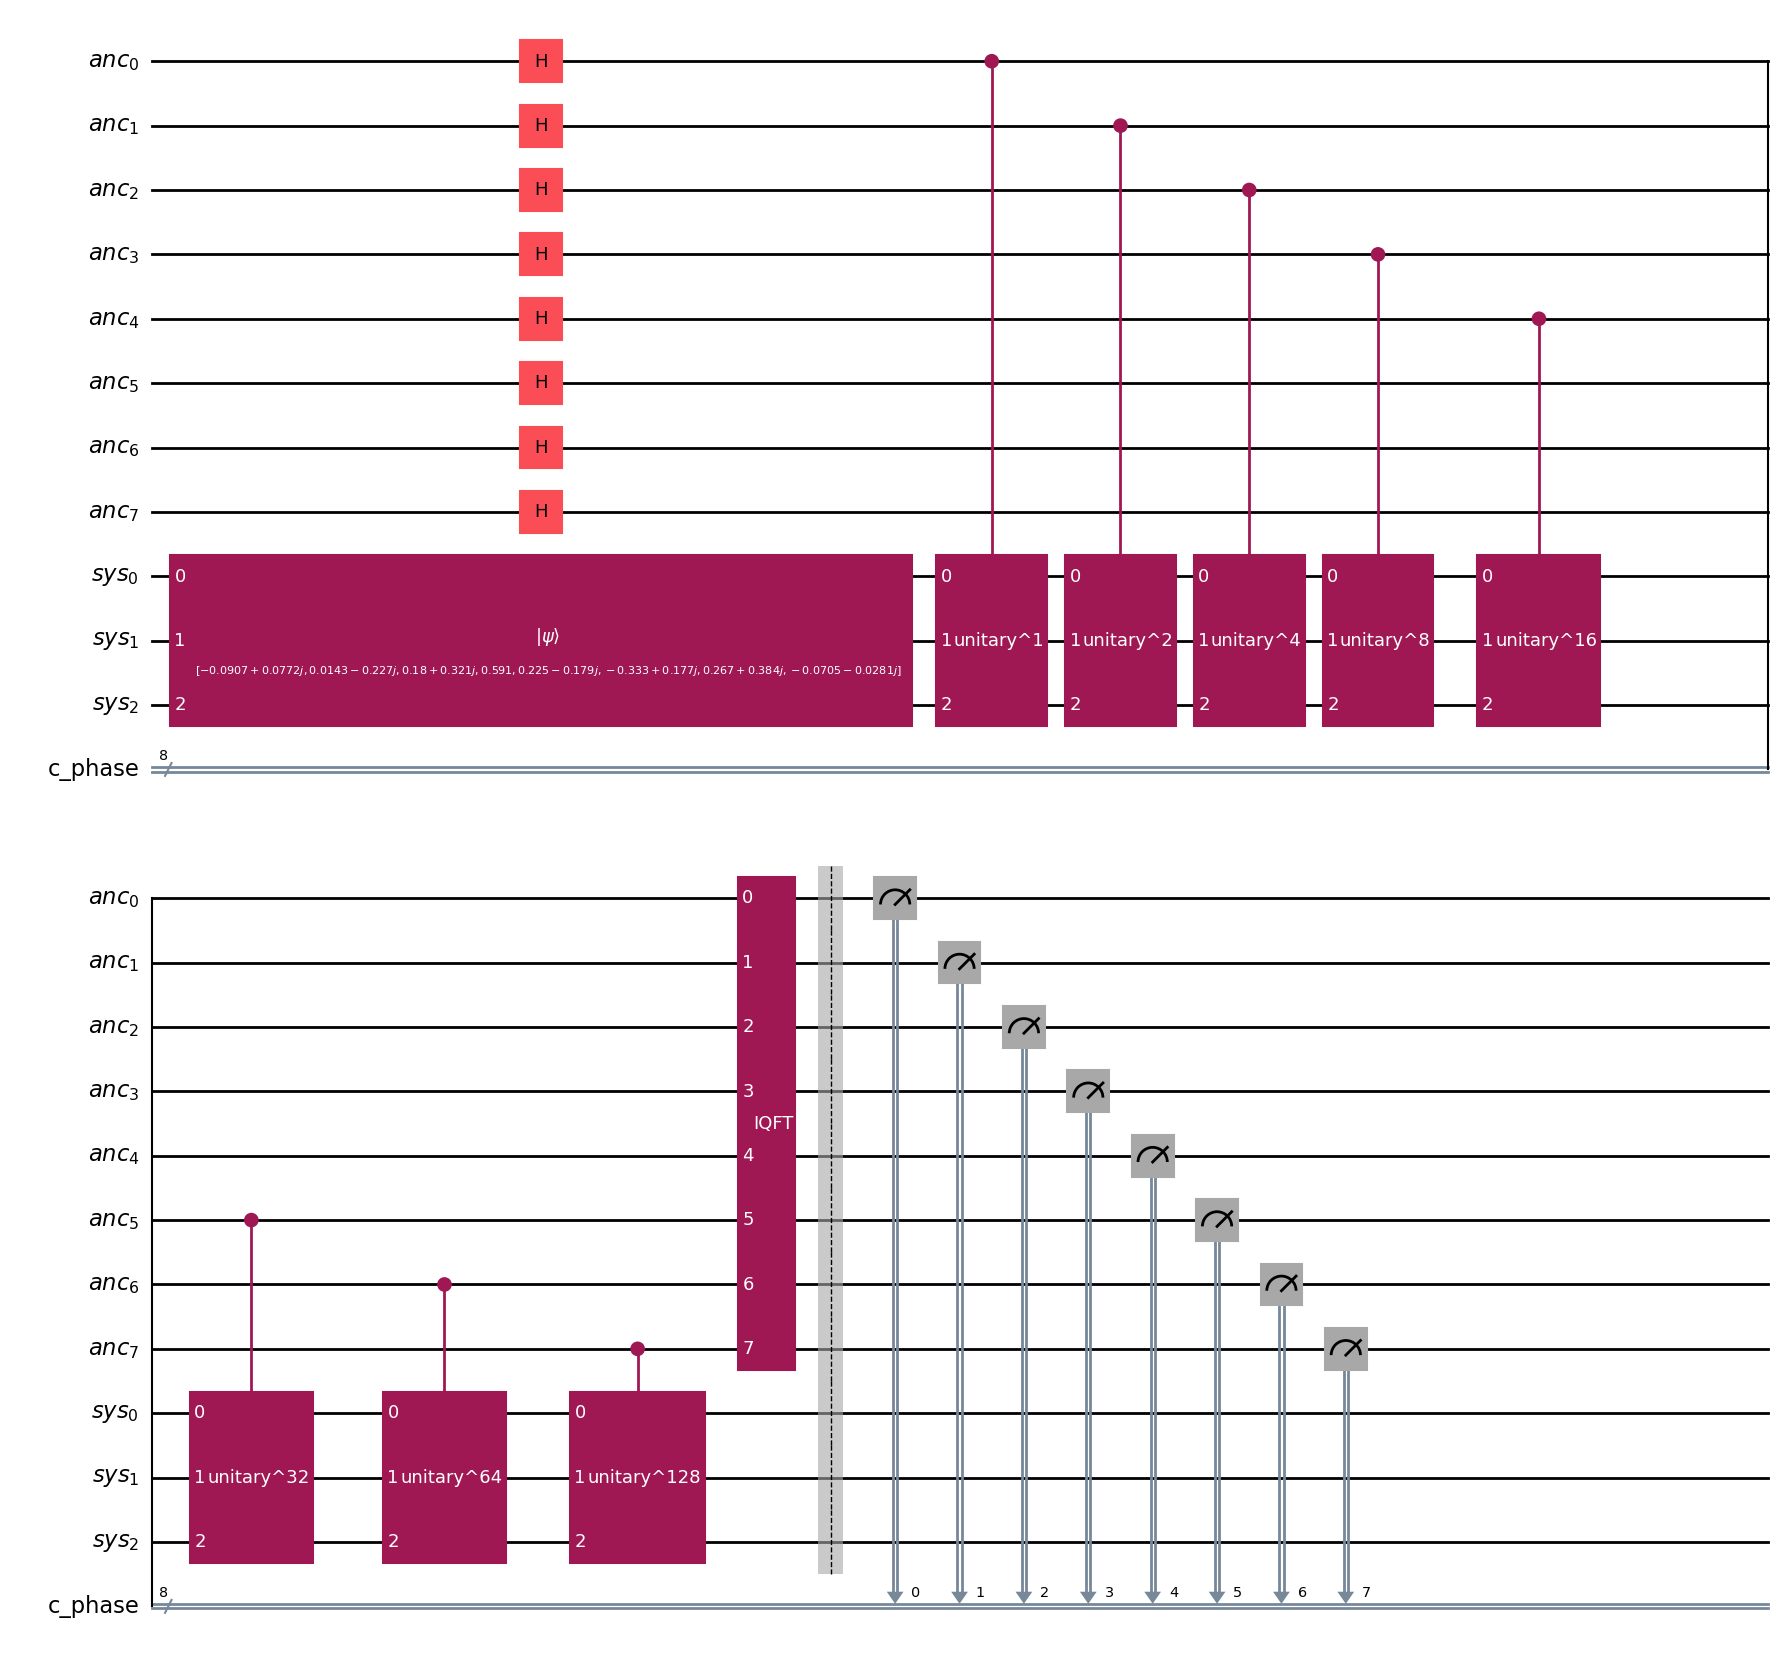

t=8 ancilla -> top bitstring 00101001 (phase=0.160156, prob=0.939)  error=0.000533


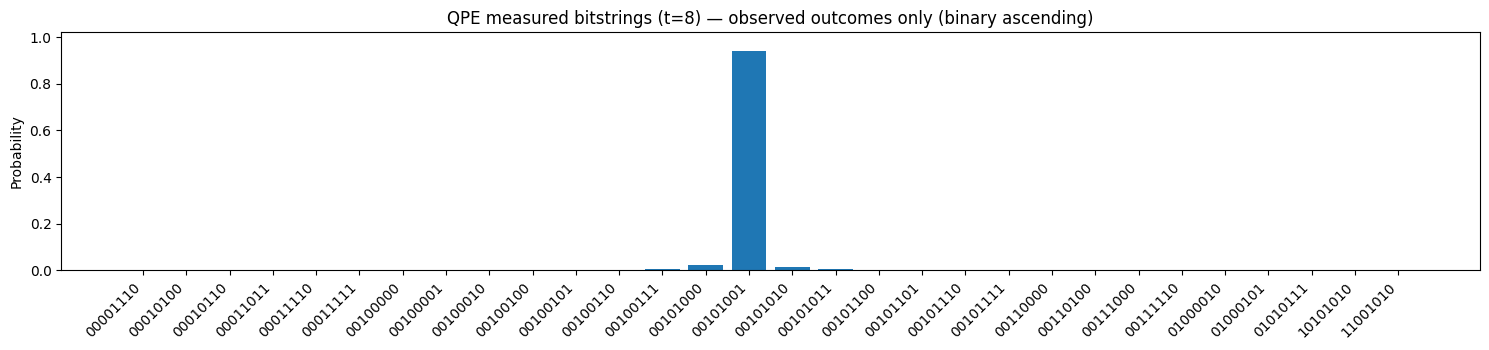

  00101001 -> 0.160156  count=3847  p=0.939
  00101000 -> 0.156250  count=90  p=0.022
  00101010 -> 0.164062  count=62  p=0.015
  00100111 -> 0.152344  count=24  p=0.006
  00101011 -> 0.167969  count=17  p=0.004
  00100110 -> 0.148438  count=9  p=0.002
-------------------------------------------------------
Done. Ancilla qubits always mapped to their own classical bits (c_phase). System qubits unmeasured.


In [70]:
# Experimental

backend = Aer.get_backend('qasm_simulator')
shots = 4096

# Reuse previously defined U (unitary) and eigenvector
assert 'U' in globals(), "Run earlier cells to define the unitary U first."
assert 'eigenvector' in globals(), "Run the eigenvector derivation cell first."

# Ensure eigenvector normalized
eigenvector = np.array([-0.09074869+0.07724145j,  0.01426988-0.22742176j,  0.18045285+0.32112435j,
  0.59063246+0.j          ,  0.22530406-0.17872043j, -0.33257214+0.17710038j,
  0.26743148+0.3839239j  , -0.07046097-0.02810309j])
_eig = eigenvector / np.linalg.norm(eigenvector)


def build_qpe(U_matrix, eigenstate, t):
    """Construct a QPE circuit with t phase (ancilla) qubits and a fixed 3‑qubit system register.
    Layout:
        ancilla register: anc[0] (LSB) ... anc[t-1] (MSB)
        system register: sys[0], sys[1], sys[2]
    Measurement: only ancilla -> classical c_phase.
    """
    anc = QuantumRegister(t, name='anc')
    sys = QuantumRegister(3, name='sys')
    c_phase = ClassicalRegister(t, name='c_phase')
    qc = QuantumCircuit(anc, sys, c_phase, name=f'QPE_t{t}')

    # 1. Prepare eigenstate on system register
    qc.initialize(eigenstate, sys)

    # 2. Put ancilla into superposition
    for k in range(t):
        qc.h(anc[k])

    # 3. Controlled U^{2^k}
    base = UnitaryGate(U_matrix, label='U')
    for k in range(t):
        power_gate = base.power(2**k).control(1)
        qc.append(power_gate, [anc[k]] + list(sys))

    # 4. Inverse QFT on ancilla using QFTGate (alias of QFT)
    iqft = QFT(num_qubits=t, inverse=True, do_swaps=True, insert_barriers=False).to_gate(label='IQFT')
    qc.append(iqft, anc)

    # 5. Measure ancilla only
    qc.barrier()
    qc.measure(anc, c_phase)
    return qc


def decode_counts(counts, t):
    """Decode phase estimates from counts dict: keys are bitstrings (MSB left)."""
    out = []
    for bitstring, c in counts.items():
        # bitstring returned left->right = anc[t-1] ... anc[0] due to swaps in IQFT
        decimal = int(bitstring, 2)
        phase = decimal / (2**t)
        out.append((bitstring, phase, c))
    out.sort(key=lambda x: x[2], reverse=True)
    return out

expected_phase = 0.15962346375  # from eigenvalue calculation
print(f"Expected phase decimal = {expected_phase:.6f}\n")

for t in [2, 4, 6, 8]:
    qc_qpe = build_qpe(U, _eig, t)
    # Show the circuit diagram (draw before transpile so it's readable)
    print(f"\nCircuit diagram for t={t} ancilla qubits:")
    display(qc_qpe.draw('mpl'))
    tqc = transpile(qc_qpe, backend, optimization_level=1)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()
    decoded = decode_counts(counts, t)
    top = decoded[0]
    print(f"t={t} ancilla -> top bitstring {top[0]} (phase={top[1]:.6f}, prob={top[2]/shots:.3f})  error={abs(top[1]-expected_phase):.6f}")

    # Build counts_by_decimal and full probs
    counts_by_decimal = {}
    for k, v in counts.items():
        k_clean = k.replace(' ', '')
        try:
            idx = int(k_clean, 2)
        except Exception:
            idx = int(k, 2)
        counts_by_decimal[idx] = v

    labels_all = [format(i, f'0{t}b') for i in range(2**t)]
    probs_all = [counts_by_decimal.get(i, 0) / shots for i in range(2**t)]

    # Only plot non-zero outcomes in ascending binary order
    plot_indices = [i for i, p in enumerate(probs_all) if p > 0]
    if not plot_indices:
        plot_indices = list(range(2**t))

    labels_plot = [labels_all[i] for i in plot_indices]
    probs_plot = [probs_all[i] for i in plot_indices]

    # Plot
    plt.figure(figsize=(max(6, len(labels_plot)*0.5), 3.6))
    x = range(len(labels_plot))
    plt.bar(x, probs_plot, color='C0')
    plt.xticks(x, labels_plot, rotation=45, ha='right')
    plt.ylim(0, 1.02)
    plt.ylabel('Probability')
    plt.title(f'QPE measured bitstrings (t={t}) — observed outcomes only (binary ascending)')
    plt.tight_layout()
    plt.show()

    # Show compact listing (top 6)
    for bit, ph, c in decoded[:6]:
        print(f"  {bit} -> {ph:.6f}  count={c}  p={c/shots:.3f}")
    print('-'*55)

print("Done. Ancilla qubits always mapped to their own classical bits (c_phase). System qubits unmeasured.")



=== t = 2 ancilla qubits ===
Circuit diagram: (skipped)


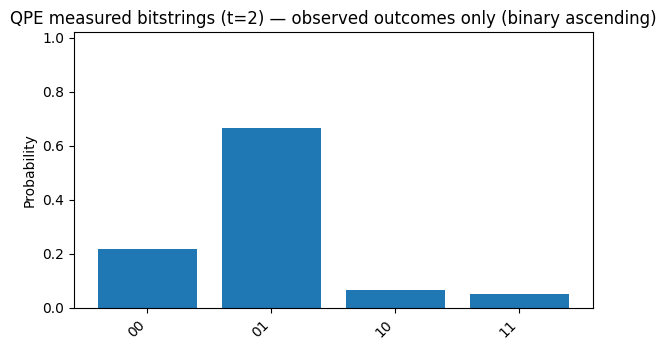


=== t = 4 ancilla qubits ===
Circuit diagram: (skipped)


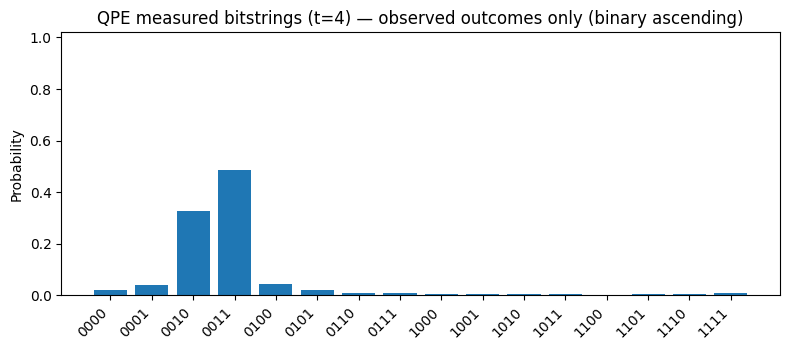


=== t = 6 ancilla qubits ===
Circuit diagram: (skipped)


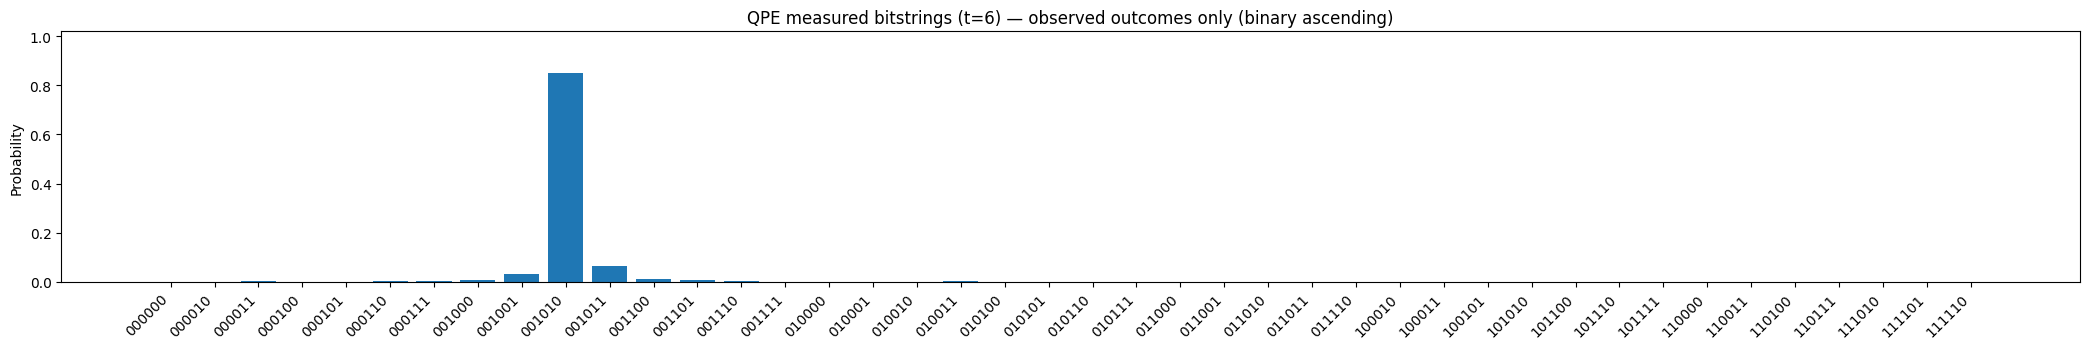


=== t = 8 ancilla qubits ===
Circuit diagram: (skipped)


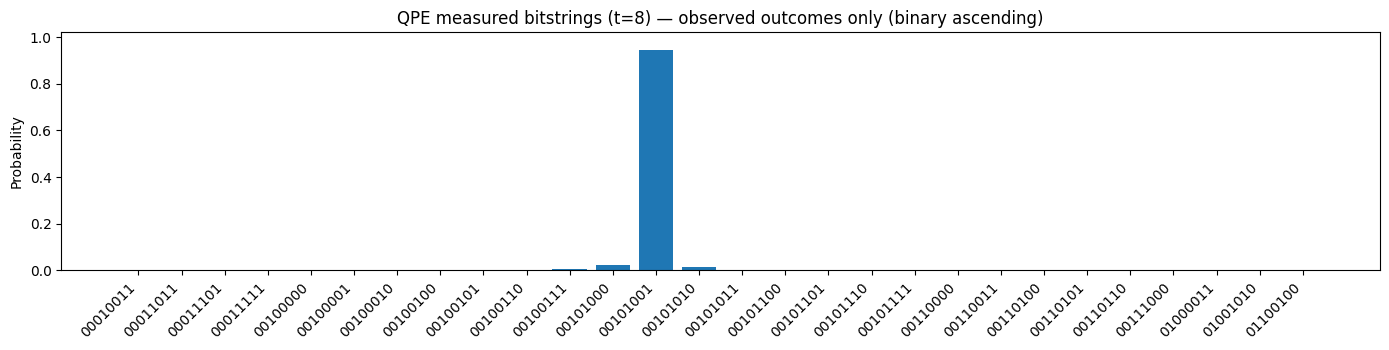

,top_bitstring,top_phase_decimal,top_prob,mean_phase,abs_error_mean,entropy_bits,distinct_outcomes
t,,,,,,,
2,01,0.250000,0.665039,0.237915,0.078292,1.349204,4
4,0011,0.187500,0.487549,0.192581,0.032958,2.085932,16
6,001010,0.156250,0.848633,0.160988,0.001364,1.063750,42
8,00101001,0.160156,0.942383,0.160229,0.000605,0.474062,28



Interpretation:
The phase we expect (from eigenvalue calculation) is approximately 0.15962346375 (decimal).

Observations:
- This phase is not an exact binary fraction with small denominator (e.g. not exactly k/2^t for small t). Therefore you should expect probability mass to spread across several nearby representable fractions on the t-bit grid, even for moderate t.
- As t increases the grid resolution improves (steps of 1/2^t). Distribution should concentrate nearer to the true phase, reducing mean absolute error and entropy, but exact concentration to a single bitstring generally requires the phase to be a rational with denominator 2^t.
- The mean_phase and abs_error_mean quantify how close the measured distribution is to the numerically computed phase; entropy quantifies spread. You should see abs_error_mean decrease and entropy fall as t increases in an ideal simulator if the eigenstate is prepared exactly.

Notes:
- These results assume an ideal (noise-free) simulator and exact 

In [71]:
# Analysis: accuracy and spread vs t
import math
import matplotlib.pyplot as plt
from IPython.display import display

# Optional pandas for a neat table
try:
    import pandas as pd
    _HAS_PANDAS = True
except Exception:
    _HAS_PANDAS = False

# Preconditions
assert 'build_qpe' in globals(), "Please run the cell that defines build_qpe() before this analysis." 
assert 'decode_counts' in globals(), "Please run the cell that defines decode_counts() before this analysis." 
assert 'U' in globals() and '_eig' in globals(), "Unitary U and eigenstate _eig must be defined by previous cells." 

# Fallbacks
backend_local = globals().get('backend')
if backend_local is None:
    from qiskit_aer import Aer
    backend_local = Aer.get_backend('qasm_simulator')
shots_local = globals().get('shots', 4096)

# Use expected numeric phase value (from eigenvalue calculation)
expected_phase = globals().get('expected_phase', 0.15962346375)  # from eigenvalue calculation

ts = [2, 4, 6, 8]
summary = []

for t in ts:
    print(f"\n=== t = {t} ancilla qubits ===")
    qc = build_qpe(U, _eig, t)

    # circuit drawing intentionally skipped in this analysis cell
    print("Circuit diagram: (skipped)")

    tqc = transpile(qc, backend_local, optimization_level=1)
    result = backend_local.run(tqc, shots=shots_local).result()
    counts = result.get_counts()

    # Build counts_by_decimal to avoid bit-order ambiguity and ensure fixed binary ascending order
    counts_by_decimal = {}
    for k, v in counts.items():
        k_clean = k.replace(' ', '')
        try:
            idx = int(k_clean, 2)
        except Exception:
            idx = int(k, 2)
        counts_by_decimal[idx] = v

    labels_all = [format(i, f'0{t}b') for i in range(2**t)]
    probs_all = [counts_by_decimal.get(i, 0) / shots_local for i in range(2**t)]
    phases_all = [i / (2**t) for i in range(2**t)]

    # Only plot non-zero outcomes in ascending binary order
    plot_indices = [i for i, p in enumerate(probs_all) if p > 0]
    if not plot_indices:
        plot_indices = list(range(2**t))

    labels_plot = [labels_all[i] for i in plot_indices]
    probs_plot = [probs_all[i] for i in plot_indices]

    # Plot histogram of only observed outcomes in ascending-binary order
    plt.figure(figsize=(max(6, len(labels_plot)*0.5), 3.6))
    x = range(len(labels_plot))
    plt.bar(x, probs_plot, color='C0')
    plt.xticks(x, labels_plot, rotation=45, ha='right')
    plt.ylim(0, 1.02)
    plt.ylabel('Probability')
    plt.title(f'QPE measured bitstrings (t={t}) — observed outcomes only (binary ascending)')
    plt.tight_layout()
    plt.show()

    # Metrics (top outcome still taken from decoded sorted-by-count list)
    decoded = decode_counts(counts, t)
    top_bit, top_phase, top_count = decoded[0]
    top_prob = top_count / shots_local
    mean_phase = sum(p * ph for p, ph in zip(probs_all, phases_all))
    abs_error = abs(mean_phase - expected_phase)
    # Shannon entropy of the measured distribution (only p>0 to avoid math domain error)
    entropy = -sum(p * math.log2(p) for p in probs_all if p > 0)

    summary.append({
        't': t,
        'top_bitstring': top_bit,
        'top_phase_decimal': top_phase,
        'top_prob': round(top_prob, 6),
        'mean_phase': mean_phase,
        'abs_error_mean': abs_error,
        'entropy_bits': entropy,
        'distinct_outcomes': len([p for p in probs_all if p > 0])
    })

# Present results as a table
if _HAS_PANDAS:
    df = pd.DataFrame(summary).set_index('t')
    display(df)
else:
    print("\nSummary table:")
    for row in summary:
        print(f"t={row['t']}: top={row['top_bitstring']} phase={row['top_phase_decimal']:.6f} top_p={row['top_prob']:.4f} mean_phase={row['mean_phase']:.6f} abs_err_mean={row['abs_error_mean']:.6f} entropy={row['entropy_bits']:.4f} outcomes={row['distinct_outcomes']}")

# Short interpretation paragraph (updated for numeric expected phase)
print('\nInterpretation:')
print('The phase we expect (from eigenvalue calculation) is approximately', expected_phase, '(decimal).')
print('')
print('Observations:')
print("- This phase is not an exact binary fraction with small denominator (e.g. not exactly k/2^t for small t). Therefore you should expect probability mass to spread across several nearby representable fractions on the t-bit grid, even for moderate t.")
print("- As t increases the grid resolution improves (steps of 1/2^t). Distribution should concentrate nearer to the true phase, reducing mean absolute error and entropy, but exact concentration to a single bitstring generally requires the phase to be a rational with denominator 2^t.")
print('- The mean_phase and abs_error_mean quantify how close the measured distribution is to the numerically computed phase; entropy quantifies spread. You should see abs_error_mean decrease and entropy fall as t increases in an ideal simulator if the eigenstate is prepared exactly.')
print('\nNotes:')
print('- These results assume an ideal (noise-free) simulator and exact eigenstate preparation. On hardware or with imperfect preparation you will see broader distributions and slower concentration.')
print('- To illustrate the quantization effect clearly, compare these results against a phase equal to a k/2^t rational (e.g. 1/16) where concentration occurs at or above the corresponding t.')
